In [ ]:
from google.colab import drive #to retrieve data from drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd 'drive/My Drive/Data/Places_data'

/content/drive/My Drive/Data/Places_data


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import math
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import pickle as pkl
import time
# district_name="Bangalore"

In [ ]:
def filter_data(district_name):
  import re
  dist_results = pd.read_csv(district_name+"_2019_all_indicators"+".csv")
  dist_results=dist_results.to_numpy()
  dist_results=dist_results[:,0:2]
  lat_coord=np.array([])
  lon_coord=np.array([])
  for i in range(dist_results.shape[0]):
    temp=re.split('\[|\]|,| ',dist_results[i,1])
    lat_coord=np.append(lat_coord,(float(temp[1])+0.005))
    lon_coord=np.append(lon_coord,(float(temp[3])+0.005))
  lat_coord=(lat_coord.reshape(lat_coord.shape[0],1))
  lon_coord=(lon_coord.reshape(lon_coord.shape[0],1))
  dist_results=dist_results[:,0].reshape(dist_results.shape[0],1)
  dist_results=np.append(dist_results,lat_coord,axis=1)
  dist_results=np.append(dist_results,lon_coord,axis=1)
  return dist_results

In [ ]:
# asd=filter_data("Mumbai")
# print(asd.shape[0])
# np.around(asd[0][2],3)

In [ ]:
# queue=[]
# queue.append(0)
# queue.append(2)
# queue.pop(0)
# ae=np.zeros(5)
# ae[0]==1
# lt=float('inf')
# lt==float('inf')

In [ ]:
# amenity_results = pd.read_csv("mumbai"+".csv")
# import re
# re.split('\n|\[|\]| ',(amenity_results.to_numpy()[721,1]))
# # dist_results=dist_results.to_numpy()

In [ ]:
# def amenity_in_grid_arr(grid_num,amenity_type):

In [ ]:
# sw=np.array([[1,2]])
# np.append(sw,np.array([[4.5,5.5],[4.6,5.5]]),axis=0)

In [ ]:
def lat_lon_to_grid_no(lat, lon, min_lat, max_lat, min_lon, max_lon):
  num_rows = np.round((max_lat - min_lat)/0.01).astype(int)
  num_cols = np.round((max_lon - min_lon)/0.01).astype(int)
  row_id_from_bottom = np.maximum(1, np.ceil((lat - min_lat)*100))
  row_id_from_bottom = np.minimum(row_id_from_bottom, num_rows) 
  col_id_from_left = np.maximum(1, np.ceil((lon - min_lon)*100))
  col_id_from_left = np.minimum(col_id_from_left, num_cols)
  grid_no = (col_id_from_left-1)*num_rows + row_id_from_bottom
  return grid_no.astype(int)

In [ ]:
def calc_hvs_dist(arr):#returns distance in meters
  # arr = np.append(grid_centre,grid_amenity_arr, axis=0)
  arr_in_radians = np.radians(arr)
  result_arr = haversine_distances(arr_in_radians)
  result_arr = (result_arr * 6371000)[0,1:]
  hvs_dist = np.min(result_arr)
  return hvs_dist

In [ ]:
# bsas = np.array([[-34.83333, -58.5166646],[12.9756177 , 77.6233864 ]])
# print(bsas.shape)
# paris = np.array([[49.0083899664, 2.53844117956]])
# paris=np.append(paris,bsas,axis=0)
# # bsas_in_radians = np.radians(bsas)
# calc_hvs_dist(paris)

In [ ]:
# x='mumbai.pkl'
# with open(x, 'rb') as f:
#     data = pkl.load(f, encoding='latin1')
# for key, value in data.items() :
#     print(key)
# np.all(data['school'][0]==None)

In [ ]:
def extract_boundaries(district_name):
  dist_coords = pd.read_csv("district_coordinates.csv")
  min_lat = np.floor(float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MinLat'])*100)/100
  max_lat = np.ceil(float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MaxLat'])*100)/100
  min_lon = np.floor(float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MinLong'])*100)/100
  max_lon = np.ceil(float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MaxLong'])*100)/100
  return (min_lat,min_lon,max_lat,max_lon)

In [ ]:
# "Sede".lower()

In [ ]:
def calc_difference_dist(arr):
  # print('arr',arr)
  arr_in_radians = np.radians(arr)
  # print('arr in radians')
  # print(arr_in_radians)
  result_arr = haversine_distances(arr_in_radians)
  # print('result_arr',result_arr)
  result_arr_row_0 = (result_arr * 6371000)[0,1:]
  sorted_dist_arr = np.sort(result_arr_row_0)
  # print('result_arr_row0',result_arr_row_0)
  # print('sorted_sidt_arr',sorted_dist_arr)
  # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
  difference_dist = sorted_dist_arr[1]-sorted_dist_arr[0]
  return difference_dist

In [ ]:
def evaluate_grid_level_parameters(district_name, amenity_type, parameter_index):
  #parameter index details
  # 1 - bfs for nearest amenity distance
  # 2 - distance between 2nd nearest and nearest amenity
  grids_arr = filter_data(district_name)
  pkl_file_name=district_name.lower()+'.pkl'
  with open(pkl_file_name, 'rb') as f:
      amenity_dict = pkl.load(f, encoding='latin1')
  grids_amenity_arr = amenity_dict[amenity_type.lower()]
  (min_lat,min_lon,max_lat,max_lon) = extract_boundaries(district_name)
  result_arr=np.array([])
  for i in range(grids_arr.shape[0]):#grids_arr.shape[0]):
    amenity_coll_arr=np.array([[np.around(grids_arr[i][1],3),np.around(grids_arr[i][2],3)]])
    visited_grid_num=np.zeros(grids_arr.shape[0])
    level_grid_num=np.zeros(grids_arr.shape[0])
    last_level=float('inf')
    found=0
    queue=[]
    queue.append(i)
    visited_grid_num[i]=1
    while queue:
      node=queue.pop(0)
      curr_lat=np.around(grids_arr[node][1],3)
      curr_lon=np.around(grids_arr[node][2],3)
      if (level_grid_num[node]==last_level):
        break
      specific_grid_amenity_arr=grids_amenity_arr[node]
      if (np.all(specific_grid_amenity_arr==None)):
        len_specific_grid_amenity_arr=0
      else:
        len_specific_grid_amenity_arr=len(specific_grid_amenity_arr)
      if (len_specific_grid_amenity_arr != 0):
        if (parameter_index == 1):
          if (found==0):
            found=1
            last_level=level_grid_num[node]+2
        if (parameter_index == 2):
          if (found==0 and len(amenity_coll_arr)>=3):
            found=1
            last_level=level_grid_num[node]+2
        amenity_coll_arr=np.append(amenity_coll_arr,specific_grid_amenity_arr,axis=0)
      right_lat=curr_lat
      right_lon=curr_lon+0.01
      if (right_lat<min_lat or right_lat>max_lat or right_lon<min_lon or right_lon>max_lon):
        pass
      else:
        right_grid=lat_lon_to_grid_no(right_lat,right_lon,min_lat,max_lat,min_lon,max_lon)-1
        if (visited_grid_num[right_grid]==0):
          level_grid_num[right_grid]=level_grid_num[node]+1
          queue.append(right_grid)
          visited_grid_num[right_grid]=1
      left_lat=curr_lat
      left_lon=curr_lon-0.01
      if (left_lat<min_lat or left_lat>max_lat or left_lon<min_lon or left_lon>max_lon):
        pass
      else:
        left_grid=lat_lon_to_grid_no(left_lat,left_lon,min_lat,max_lat,min_lon,max_lon)-1
        if (visited_grid_num[left_grid]==0):
          level_grid_num[left_grid]=level_grid_num[node]+1
          queue.append(left_grid)
          visited_grid_num[left_grid]=1
      top_lat=curr_lat+0.01
      top_lon=curr_lon
      if (top_lat<min_lat or top_lat>max_lat or top_lon<min_lon or top_lon>max_lon):
        pass
      else:
        top_grid=lat_lon_to_grid_no(top_lat,top_lon,min_lat,max_lat,min_lon,max_lon)-1
        if (visited_grid_num[top_grid]==0):
          level_grid_num[top_grid]=level_grid_num[node]+1
          queue.append(top_grid)
          visited_grid_num[top_grid]=1
      bottom_lat=curr_lat-0.01
      bottom_lon=curr_lon
      if (bottom_lat<min_lat or bottom_lat>max_lat or bottom_lon<min_lon or bottom_lon>max_lon):
        pass
      else:
        bottom_grid=lat_lon_to_grid_no(bottom_lat,bottom_lon,min_lat,max_lat,min_lon,max_lon)-1
        if (visited_grid_num[bottom_grid]==0):
          level_grid_num[bottom_grid]=level_grid_num[node]+1
          queue.append(bottom_grid)
          visited_grid_num[bottom_grid]=1
    if (parameter_index == 1):
      hvs_distance=calc_hvs_dist(amenity_coll_arr)
      result_arr=np.append(result_arr,np.array([hvs_distance]))
    if (parameter_index == 2):
      difference_distance=calc_difference_dist(amenity_coll_arr)
      result_arr=np.append(result_arr,np.array([difference_distance]))
  return result_arr

In [ ]:
# type(str(3))

In [ ]:
# district_name='Mumbai'
# category_list=np.array(['school','primary_school'])
# dist_list=[]
# for i in range(len(category_list)):
#   dist_list.append(evaluate_grid_level_parameters(district_name, category_list[i], 1))
# dist_list
# data = {'Grid_Number': [i for i in range(0, np.shape(ans)[0])], amenity_type: ans/1000.0}
# df = pd.DataFrame(data, columns = data.keys())
# df.to_csv(district_name + '_nearest_'+amenity_type+'_from_each_centre_grid.csv', index=False)#distance is in km

In [ ]:

# ans=dist_list[0]
# for i in range(len(dist_list)-1):
#   ans=np.minimum(ans,dist_list[i+1])
# # ans.shape

In [ ]:
def create_nearest_amenity_distance_from_each_centre_csv_file(district_name, category_name, category_list):
  distance_list=[]
  for i in range(len(category_list)):
    distance_list.append(evaluate_grid_level_parameters(district_name, category_list[i], 1))
  # (np.shape(ans)[0])
  ans=distance_list[0]
  for i in range(len(distance_list)-1):
    ans=np.minimum(ans,distance_list[i+1])
  data = {'Grid_Number': [i for i in range(0, np.shape(ans)[0])], category_name: ans/1000.0}
  df = pd.DataFrame(data, columns = data.keys())
  df.to_csv(district_name + '_nearest_'+category_name+'_from_each_grid_centre.csv', index=False)#distance is in km

In [ ]:
# category_dict={"Education":['school','primary_school'],"Health":['doctor','hospital'],"Connectivity":['train_station','taxi_stand','bus_station'],"Utilities":['department_store','supermarket'],"Government_Facilities":['local_government_office','police','bank']}
# for key in category_dict:
#   print(key, category_dict[key])
# type(key)

In [ ]:
start_time=time.time()
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":['school','primary_school'],"Health":['doctor','hospital'],"Connectivity":['train_station','taxi_stand','bus_station'],"Utilities":['department_store','supermarket'],"Government_Facilities":['local_government_office','police','bank']}
for i in range(len(districts)):
  for key in category_dict:
    create_nearest_amenity_distance_from_each_centre_csv_file(districts[i],key,category_dict[key])#distance is in km
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)

done for district Bangalore for category Education in time  28.38623571395874
done for district Bangalore for category Health in time  66.51805186271667


KeyboardInterrupt: ignored

In [ ]:
# def create_difference_distance_bw_nearest_next_nearest_amenity_from_each_centre_csv_file(district_name, category_name, category_list):
#   diff_dist_list=[]
#   for i in range(len(category_list)):
#     diff_dist_list.append(evaluate_grid_level_parameters(district_name, category_list[i], 2))
#   ans=diff_dist_list[0]
#   # (np.shape(ans)[0])
#   for i in range(len(diff_dist_list)-1):
#     ans=np.minimum(ans,diff_dist_list[i+1])
#   data = {'Grid_Number': [i for i in range(0, np.shape(ans)[0])], category_name: ans/1000.0}
#   df = pd.DataFrame(data, columns = data.keys())
#   df.to_csv(district_name + '_difference_distance_bw_nearest_next_nearest_'+category_name+'_from_each_grid_centre.csv', index=False)#distance is in km

In [ ]:
# districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
# category_dict={"Education":['school','primary_school'],"Health":['doctor','hospital'],"Connectivity":['train_station','taxi_stand','bus_station'],"Utilities":['department_store','supermarket'],"Government_Facilities":['local_government_office','police','bank']}
# for i in range(len(districts)):
#   start_time=time.time()
#   for key in category_dict:
#     create_difference_distance_bw_nearest_next_nearest_amenity_from_each_centre_csv_file(districts[i],key,category_dict[key])
#     print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)

In [ ]:
# fn='Mumbai' + '_nearest_'+'school'+'_from_each_centre_grid.csv'
# temp = pd.read_csv(fn)
# temp=temp.to_numpy()
# np.around(np.mean(temp[:,1]),5)

In [ ]:
# np.mean(np.array([3,4,10,4]))

In [ ]:
# tempo

In [ ]:
# np.where(tempo==np.min(tempo))

In [ ]:
# pkl_file_name='mumbai'+'.pkl'
# with open(pkl_file_name, 'rb') as f:
#     amenity_dict = pkl.load(f, encoding='latin1')
# grids_amenity_arr = amenity_dict['school']
# (grids_amenity_arr)
# for i in range(len(grids_amenity_arr)):
#   print(i, grids_amenity_arr[i])

In [ ]:
# import re
# dist_results = pd.read_csv('Mumbai'+"_2019_all_indicators"+".csv")
# dist_results=dist_results.to_numpy()
# grid_type_arr=(dist_results[:,7]).reshape(grid_type_arr.shape[0],1)
# print(grid_type_arr.shape)
# dist_results=dist_results[:,0:2]
# lat_coord=np.array([])
# lon_coord=np.array([])
# for i in range(dist_results.shape[0]):
#   temp=re.split('\[|\]|,| ',dist_results[i,1])
#   lat_coord=np.append(lat_coord,(float(temp[1])+0.005))
#   lon_coord=np.append(lon_coord,(float(temp[3])+0.005))
# lat_coord=(lat_coord.reshape(lat_coord.shape[0],1))
# lon_coord=(lon_coord.reshape(lon_coord.shape[0],1))
# dist_results=dist_results[:,0].reshape(dist_results.shape[0],1)
# dist_results=np.append(dist_results,lat_coord,axis=1)
# dist_results=np.append(dist_results,lon_coord,axis=1)
# dist_results=np.append(dist_results,grid_type_arr,axis=1)
# dist_results

In [ ]:
def get_grid_info(district_name,year):
  import re
  dist_results = pd.read_csv(district_name+"_"+str(year)+"_all_indicators"+".csv")
  dist_results=dist_results.to_numpy()
  grid_type_arr=(dist_results[:,7]).reshape(dist_results.shape[0],1)
  grid_class_arr=(dist_results[:,11]).reshape(dist_results.shape[0],1)
  dist_results=dist_results[:,0:2]
  lat_coord=np.array([])
  lon_coord=np.array([])
  for i in range(dist_results.shape[0]):
    temp=re.split('\[|\]|,| ',dist_results[i,1])
    lat_coord=np.append(lat_coord,(float(temp[1])+0.005))
    lon_coord=np.append(lon_coord,(float(temp[3])+0.005))
  lat_coord=(lat_coord.reshape(lat_coord.shape[0],1))
  lon_coord=(lon_coord.reshape(lon_coord.shape[0],1))
  dist_results=dist_results[:,0].reshape(dist_results.shape[0],1)
  dist_results=np.append(dist_results,lat_coord,axis=1)
  dist_results=np.append(dist_results,lon_coord,axis=1)
  dist_results=np.append(dist_results,grid_type_arr,axis=1)
  dist_results=np.append(dist_results,grid_class_arr,axis=1)
  return dist_results

In [ ]:
# pkl_file_name='mumbai'+'.pkl'
# with open(pkl_file_name, 'rb') as f:
#     amenity_dict = pkl.load(f, encoding='latin1')
# # grids_amenity_arr = amenity_dict['school']
# # (grids_amenity_arr)
# # for i in range(len(grids_amenity_arr)):
# #   print(i, grids_amenity_arr[i])
# amenity_dict.keys()

In [ ]:
def count_amenities_in_range(arr, last_level):
  arr_in_radians = np.radians(arr)
  # print('arr in radians')
  # print(arr_in_radi/ans)
  result_arr = haversine_distances(arr_in_radians)
  # print('result_arr',result_arr)
  result_arr_row_0 = (result_arr * 6371000)[0,1:]
  sorted_dist_arr = np.sort(result_arr_row_0)
  # print('result_arr_row0',result_arr_row_0)
  # print('sorted_sidt_arr',sorted_dist_arr)
  # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
  # difference_dist = sorted_dist_arr[1]-sorted_dist_arr[0]
  if (last_level==4):
    dist_limit=2000
  elif (last_level==1):
    dist_limit=400
  elif (last_level==3):
    dist_limit=800
  else:
    dist_limit=5000
  num_amenities=0
  for i in range(len(sorted_dist_arr)):
    if (sorted_dist_arr[i] > dist_limit):
      num_amenities=i+1
      break
  return num_amenities

In [ ]:
def evaluate_num_grids(district_name,amenity_type,year):
  grids_arr = get_grid_info(district_name,year)#year=2016 or 2019
  pkl_file_name=district_name.lower()+'.pkl'
  with open(pkl_file_name, 'rb') as f:
      amenity_dict = pkl.load(f, encoding='latin1')
  grids_amenity_arr = amenity_dict[amenity_type.lower()]
  (min_lat,min_lon,max_lat,max_lon) = extract_boundaries(district_name)
  result_arr=np.array([])
  for i in range(grids_arr.shape[0]):
    amenity_coll_arr=np.array([[np.around(grids_arr[i][1],3),np.around(grids_arr[i][2],3)]])
    visited_grid_num=np.zeros(grids_arr.shape[0])
    level_grid_num=np.zeros(grids_arr.shape[0])
    grid_status=grids_arr[i][3]
    if (grid_status=='Rejected' or grid_status=='Rural'):
      last_level=10
    else:
      if (amenity_type=='taxi_stand' or amenity_type=='bus_station'):
        last_level=1
      elif (amenity_type=='supermarket' or amenity_type=='department_store' or amenity_type=='train_station'):
        last_level=3
      else:
        last_level=4
    # last_level=float('inf')
    # found=0
    queue=[]
    queue.append(i)
    visited_grid_num[i]=1
    while queue:
      node=queue.pop(0)
      curr_lat=np.around(grids_arr[node][1],3)
      curr_lon=np.around(grids_arr[node][2],3)
      if (level_grid_num[node]==last_level):
        break
      specific_grid_amenity_arr=grids_amenity_arr[node]
      if (np.all(specific_grid_amenity_arr==None)):
        len_specific_grid_amenity_arr=0
      else:
        len_specific_grid_amenity_arr=len(specific_grid_amenity_arr)
      if (len_specific_grid_amenity_arr != 0):
        # if (parameter_index == 1):
        #   if (found==0):
        #     found=1
        #     last_level=level_grid_num[node]+2
        # if (parameter_index == 2):
        #   if (found==0 and len(amenity_coll_arr)>=3):
        #     found=1
        #     last_level=level_grid_num[node]+2
        amenity_coll_arr=np.append(amenity_coll_arr,specific_grid_amenity_arr,axis=0)
      right_lat=curr_lat
      right_lon=curr_lon+0.01
      if (right_lat<min_lat or right_lat>max_lat or right_lon<min_lon or right_lon>max_lon):
        pass
      else:
        right_grid=lat_lon_to_grid_no(right_lat,right_lon,min_lat,max_lat,min_lon,max_lon)-1
        if (visited_grid_num[right_grid]==0):
          level_grid_num[right_grid]=level_grid_num[node]+1
          queue.append(right_grid)
          visited_grid_num[right_grid]=1
      left_lat=curr_lat
      left_lon=curr_lon-0.01
      if (left_lat<min_lat or left_lat>max_lat or left_lon<min_lon or left_lon>max_lon):
        pass
      else:
        left_grid=lat_lon_to_grid_no(left_lat,left_lon,min_lat,max_lat,min_lon,max_lon)-1
        if (visited_grid_num[left_grid]==0):
          level_grid_num[left_grid]=level_grid_num[node]+1
          queue.append(left_grid)
          visited_grid_num[left_grid]=1
      top_lat=curr_lat+0.01
      top_lon=curr_lon
      if (top_lat<min_lat or top_lat>max_lat or top_lon<min_lon or top_lon>max_lon):
        pass
      else:
        top_grid=lat_lon_to_grid_no(top_lat,top_lon,min_lat,max_lat,min_lon,max_lon)-1
        if (visited_grid_num[top_grid]==0):
          level_grid_num[top_grid]=level_grid_num[node]+1
          queue.append(top_grid)
          visited_grid_num[top_grid]=1
      bottom_lat=curr_lat-0.01
      bottom_lon=curr_lon
      if (bottom_lat<min_lat or bottom_lat>max_lat or bottom_lon<min_lon or bottom_lon>max_lon):
        pass
      else:
        bottom_grid=lat_lon_to_grid_no(bottom_lat,bottom_lon,min_lat,max_lat,min_lon,max_lon)-1
        if (visited_grid_num[bottom_grid]==0):
          level_grid_num[bottom_grid]=level_grid_num[node]+1
          queue.append(bottom_grid)
          visited_grid_num[bottom_grid]=1
    # if (parameter_index == 1):
    #   hvs_distance=calc_hvs_dist(amenity_coll_arr)
    #   result_arr=np.append(result_arr,np.array([hvs_distance]))
    # if (parameter_index == 2):
    #   difference_distance=calc_difference_dist(amenity_coll_arr)
    #   result_arr=np.append(result_arr,np.array([difference_distance]))
    if (len(amenity_coll_arr)==1):
      num_amenitites=0
    else:
      num_amenitites=count_amenities_in_range(amenity_coll_arr, last_level)
    result_arr=np.append(result_arr,num_amenitites)
  return result_arr

In [ ]:
# len(np.array([[2,3]]))

In [ ]:
# evaluate_num_grids('Mumbai','school',2019)

In [ ]:
def create_num_amenities_within_std_range_from_each_centre_csv_file(district_name, category_name, category_list, year):
  num_list=[]
  for i in range(len(category_list)):
    num_list.append(evaluate_num_grids(district_name, category_list[i], year))
  ans=num_list[0]
  # (np.shape(ans)[0])
  for i in range(len(num_list)-1):
    ans=np.add(ans,num_list[i+1])
  data = {'Grid_Number': [i for i in range(0, np.shape(ans)[0])], category_name: ans}
  df = pd.DataFrame(data, columns = data.keys())
  df.to_csv(district_name + '_num_'+category_name+'_within_std_range_from_each_grid_centre_'+str(year)+'.csv', index=False)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":['school','primary_school'],"Health":['doctor','hospital'],"Connectivity":['train_station','taxi_stand','bus_station'],"Utilities":['department_store','supermarket'],"Government_Facilities":['local_government_office','police','bank']}
for i in range(len(districts)):
  for key in category_dict:
    start_time=time.time()
    create_num_amenities_within_std_range_from_each_centre_csv_file(districts[i],key,category_dict[key],2019)
    # create_num_amenities_within_std_range_from_each_centre_csv_file(districts[i],amenities[j],2016)
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)

done for district Bangalore for category Education in time  236.51364254951477
done for district Bangalore for category Health in time  207.0389051437378
done for district Bangalore for category Connectivity in time  210.36992049217224
done for district Bangalore for category Utilities in time  150.4318187236786
done for district Bangalore for category Government_Facilities in time  222.2423551082611
done for district Chennai for category Education in time  15.22268271446228
done for district Chennai for category Health in time  22.078903913497925
done for district Chennai for category Connectivity in time  7.958559513092041
done for district Chennai for category Utilities in time  7.935060739517212
done for district Chennai for category Government_Facilities in time  13.203288793563843
done for district Delhi for category Education in time  183.24405193328857
done for district Delhi for category Health in time  164.22955107688904
done for district Delhi for category Connectivity in ti

In [ ]:
def create_num_amenities_in_each_grid_csv_file(district_name, category_name, category_list):
  num_list=[]
  pkl_file_name=district_name.lower()+'.pkl'
  with open(pkl_file_name, 'rb') as f:
      amenity_dict = pkl.load(f, encoding='latin1')
  for j in range(len(category_list)):
    grids_amenity_arr = amenity_dict[(category_list[j]).lower()]
    num_arr=np.array([])
    for i in range(len(grids_amenity_arr)):
      if (np.all(grids_amenity_arr[i]==None)):
        len_arr=0
      else:
        len_arr=len(grids_amenity_arr[i])
      num_arr=np.append(num_arr,len_arr)
    num_list.append(num_arr)
  ans=num_list[0]
  for j in range(len(num_list)-1):
    ans=np.add(ans,num_list[j+1])
  data = {'Grid_Number': [i for i in range(0, np.shape(ans)[0])], category_name: ans}
  df = pd.DataFrame(data, columns = data.keys())
  df.to_csv(district_name + '_num_'+category_name+'_in_each_grid'+'.csv', index=False)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":['school','primary_school'],"Health":['doctor','hospital'],"Connectivity":['train_station','taxi_stand','bus_station'],"Utilities":['department_store','supermarket'],"Government_Facilities":['local_government_office','police','bank']}
for i in range(len(districts)):
  for key in category_dict:
    start_time=time.time()
    create_num_amenities_in_each_grid_csv_file(districts[i],key,category_dict[key])
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)

done for district Bangalore for category Education in time  0.32361936569213867
done for district Bangalore for category Health in time  0.3136470317840576
done for district Bangalore for category Connectivity in time  0.43160486221313477
done for district Bangalore for category Utilities in time  0.29430341720581055
done for district Bangalore for category Government_Facilities in time  0.35298848152160645
done for district Chennai for category Education in time  0.49764347076416016
done for district Chennai for category Health in time  0.032427072525024414
done for district Chennai for category Connectivity in time  0.03525280952453613
done for district Chennai for category Utilities in time  0.03604531288146973
done for district Chennai for category Government_Facilities in time  0.03605842590332031
done for district Delhi for category Education in time  0.6049718856811523
done for district Delhi for category Health in time  0.18578886985778809
done for district Delhi for category C

In [ ]:
# pkl_file_name='mumbai'+'.pkl'
# with open(pkl_file_name, 'rb') as f:
#     amenity_dict = pkl.load(f, encoding='latin1')
# grids_amenity_arr = amenity_dict['school']
# ans_arr=np.array([])
# for i in range(len(grids_amenity_arr)):
#   if (np.all(grids_amenity_arr[i]==None)):
#     len_arr=0
#   else:
#     len_arr=len(grids_amenity_arr[i])
#   ans_arr=np.append(ans_arr,len_arr)
#   # print(i,len_arr)
#   # print(i,grids_amenity_arr[i])

# print(np.sum(ans_arr))

In [ ]:
# (np.array([2,3,4,5])).shape[0]

In [ ]:
# def create_csv_file_for_cdf_for_combined_grids_for_nearest_amenity_dist(district_name,amenity_type,year):
#   filename = district_name + '_nearest_'+amenity_type+'_from_each_centre_grid.csv'
#   grids_info=get_grid_info(district_name,year)
#   num_arr=pd.read_csv(filename)
#   num_arr=num_arr.to_numpy()
#   num_arr = num_arr[:,1] 
#   grid_num=np.arange(num_arr.shape[0])
#   grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
#   combined_grids_dist=num_arr[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
#   data = {'Grid_Number': grid_num, amenity_type: combined_grids_dist}
#   df = pd.DataFrame(data, columns = data.keys())
#   df.to_csv('CDF_plot_data_of_combined_grids_for_'+district_name + '_for_nearest_'+amenity_type+'_distance_in_km'+'.csv', index=False)

In [ ]:
# districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
# amenities=['local_government_office','school','police','doctor','train_station','department_store','supermarket','primary_school','taxi_stand','bus_station','hospital','bank']
# for i in range(len(districts)):
#   for j in range(len(amenities)):
#     start_time=time.time()
#     create_csv_file_for_cdf_for_combined_grids_for_nearest_amenity_dist(districts[i],amenities[j],2019)
#     print('done for district '+districts[i]+' for amenity '+amenities[j]+' in time ',time.time()-start_time)

In [ ]:
def percentile_value_for_nearest_amenity_dist_for_combined_grids(district_name,category_name,year):#using 80 percentile distance
  filename = district_name + '_nearest_'+category_name+'_from_each_grid_centre.csv'
  grids_info=get_grid_info(district_name,year)
  num_arr=pd.read_csv(filename)
  num_arr=num_arr.to_numpy()
  num_arr = num_arr[:,1] 
  # grid_num=np.arange(num_arr.shape[0])
  # grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  combined_grids_dist=num_arr[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  return_value = np.percentile(combined_grids_dist,80)
  return return_value
  # data = {'Grid_Number': grid_num, amenity_type: combined_grids_dist}
  # df = pd.DataFrame(data, columns = data.keys())
  # df.to_csv('CDF_plot_data_of_combined_grids_for_'+district_name + '_for_nearest_'+amenity_type+'_distance_in_km'+'.csv', index=False)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
for i in range(len(districts)):
  for key in category_dict:
    start_time=time.time()
    category_dict[key].append(percentile_value_for_nearest_amenity_dist_for_combined_grids(districts[i],key,2019))
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Histogram_data_of_combined_grids_for_' + '_for_nearest_'+'category'+'_distance_in_km'+'.csv', index=False)

done for district Bangalore for category Education in time  0.9362444877624512
done for district Bangalore for category Health in time  0.556936502456665
done for district Bangalore for category Connectivity in time  0.4916725158691406
done for district Bangalore for category Utilities in time  0.5473957061767578
done for district Bangalore for category Government_Facilities in time  0.56715989112854
done for district Chennai for category Education in time  0.9758849143981934
done for district Chennai for category Health in time  0.32984042167663574
done for district Chennai for category Connectivity in time  0.5380549430847168
done for district Chennai for category Utilities in time  0.38272929191589355
done for district Chennai for category Government_Facilities in time  0.4999690055847168
done for district Delhi for category Education in time  0.9704232215881348
done for district Delhi for category Health in time  0.5042788982391357
done for district Delhi for category Connectivity 

In [ ]:
def percentile_value_for_nearest_amenity_dist_for_Cz_grids(district_name,category_name,year,z):#using 80 percentile distance, z=1/2/3/4/5
  filename = district_name + '_nearest_'+category_name+'_from_each_grid_centre.csv'
  grids_info=get_grid_info(district_name,year)
  num_arr=pd.read_csv(filename)
  num_arr=num_arr.to_numpy()
  num_arr = num_arr[:,1]
  cx_grids_dist=num_arr[(grids_info[:,4]==z)]
  return_value = np.percentile(cx_grids_dist,80)
  return return_value

In [ ]:
for k in range(5):
  districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
  mod_districts=['Bangalore','Chennai','Delhi','Gurgaon','Kolkata','Mumbai']#as Hyderabad has 0 C1 grids in 2019
  category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
  for i in range(len(districts)):
    for key in category_dict:
      if ((k+1)==1 and i==4):#as Hyderabad has 0 C1 grids in 2019
        pass
      else:
        start_time=time.time()
        category_dict[key].append(percentile_value_for_nearest_amenity_dist_for_Cz_grids(districts[i],key,2019,(k+1)))
        print('done for district '+districts[i]+' for category '+key+' for class = '+str(k+1)+' in time ',time.time()-start_time)
  if ((k+1)==1):
    data = {'Districts': mod_districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Histogram_data_of_C'+str(k+1)+'_grids_for_' + '_for_nearest_'+'category'+'_distance_in_km'+'.csv', index=False)
  else:
    data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Histogram_data_of_C'+str(k+1)+'_grids_for_' + '_for_nearest_'+'category'+'_distance_in_km'+'.csv', index=False)

done for district Bangalore for category Education for class = 1 in time  0.06016254425048828
done for district Bangalore for category Health for class = 1 in time  0.05716657638549805
done for district Bangalore for category Connectivity for class = 1 in time  0.05699491500854492
done for district Bangalore for category Utilities for class = 1 in time  0.05677652359008789
done for district Bangalore for category Government_Facilities for class = 1 in time  0.0787959098815918
done for district Chennai for category Education for class = 1 in time  0.011358261108398438
done for district Chennai for category Health for class = 1 in time  0.014040946960449219
done for district Chennai for category Connectivity for class = 1 in time  0.01267385482788086
done for district Chennai for category Utilities for class = 1 in time  0.011889934539794922
done for district Chennai for category Government_Facilities for class = 1 in time  0.012207746505737305
done for district Delhi for category Educat

In [ ]:
# def create_csv_file_for_cdf_for_combined_grids_for_num_amenities_within_std_range(district_name,amenity_type,year):
#   filename = district_name + '_num_'+amenity_type+'_within_std_range_from_each_centre_grid_'+str(year)+'.csv'
#   grids_info=get_grid_info(district_name,year)
#   num_arr=pd.read_csv(filename)
#   num_arr=num_arr.to_numpy()
#   num_arr = num_arr[:,1]
#   grid_num=np.arange(num_arr.shape[0])
#   grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
#   combined_grids=num_arr[(np.logical_or((grids_info[:,3]=='PeriUrban'),(grids_info[:,3]=='Urban')))]
#   data = {'Grid_Number': grid_num, amenity_type: combined_grids}
#   df = pd.DataFrame(data, columns = data.keys())
#   df.to_csv('CDF_plot_data_of_combined_grids_for_'+district_name + '_for_number_of_'+amenity_type+'_within_std_range'+'.csv', index=False)

In [ ]:
# districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
# amenities=['local_government_office','school','police','doctor','train_station','department_store','supermarket','primary_school','taxi_stand','bus_station','hospital','bank']
# for i in range(len(districts)):
#   for j in range(len(amenities)):
#     start_time=time.time()
#     create_csv_file_for_cdf_for_combined_grids_for_num_amenities_within_std_range(districts[i],amenities[j],2019)
#     print('done for district '+districts[i]+' for amenity '+amenities[j]+' in time ',time.time()-start_time)

In [ ]:
def percentile_value_for_num_amenities_within_std_rangefor_combined_grids(district_name,category_name,year):#20 percentile value
  filename = district_name + '_num_'+category_name+'_within_std_range_from_each_grid_centre_'+str(year)+'.csv'
  grids_info=get_grid_info(district_name,year)
  num_arr=pd.read_csv(filename)
  num_arr=num_arr.to_numpy()
  num_arr = num_arr[:,1]
  # grid_num=np.arange(num_arr.shape[0])
  # grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  combined_grids=num_arr[(np.logical_or((grids_info[:,3]=='PeriUrban'),(grids_info[:,3]=='Urban')))]
  return_value=int(np.percentile(combined_grids,20))
  return return_value
  # data = {'Grid_Number': grid_num, amenity_type: combined_grids}
  # df = pd.DataFrame(data, columns = data.keys())
  # df.to_csv('CDF_plot_data_of_combined_grids_for_'+district_name + '_for_number_of_'+amenity_type+'_within_std_range'+'.csv', index=False)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
for i in range(len(districts)):
  for key in category_dict:
    start_time=time.time()
    category_dict[key].append(percentile_value_for_num_amenities_within_std_rangefor_combined_grids(districts[i],key,2019))
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Histogram_data_of_combined_grids_for_' + '_num_'+'category'+'_within_std_distance'+'.csv', index=False)

done for district Bangalore for category Education in time  0.06107449531555176
done for district Bangalore for category Health in time  0.056386470794677734
done for district Bangalore for category Connectivity in time  0.057540178298950195
done for district Bangalore for category Utilities in time  0.059526920318603516
done for district Bangalore for category Government_Facilities in time  0.06339883804321289
done for district Chennai for category Education in time  0.011829614639282227
done for district Chennai for category Health in time  0.011183023452758789
done for district Chennai for category Connectivity in time  0.010534286499023438
done for district Chennai for category Utilities in time  0.011055231094360352
done for district Chennai for category Government_Facilities in time  0.011524200439453125
done for district Delhi for category Education in time  0.05013108253479004
done for district Delhi for category Health in time  0.05061006546020508
done for district Delhi for c

In [ ]:
# np.percentile([1,10],50)

In [ ]:
def percentile_value_for_num_amenities_within_std_range_for_Cz_grids(district_name,category_name,year,z):#80 percentile value; z=1/2/3/4/5
  filename = district_name + '_num_'+category_name+'_within_std_range_from_each_grid_centre_'+str(year)+'.csv'
  grids_info=get_grid_info(district_name,year)
  num_arr=pd.read_csv(filename)
  num_arr=num_arr.to_numpy()
  num_arr = num_arr[:,1]
  cz_grids=num_arr[(grids_info[:,4]==z)]
  return_value=int(np.percentile(cz_grids,20))
  return return_value

In [ ]:
for k in range(5):
  districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
  mod_districts=['Bangalore','Chennai','Delhi','Gurgaon','Kolkata','Mumbai']#as Hyderabad has 0 C1 grids in 2019
  category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
  for i in range(len(districts)):
    for key in category_dict:
      if ((k+1)==1 and i==4):#as Hyderabad has 0 C1 grids in 2019
        pass
      else:
        start_time=time.time()
        category_dict[key].append(percentile_value_for_num_amenities_within_std_range_for_Cz_grids(districts[i],key,2019,(k+1)))
        print('done for district '+districts[i]+' for category '+key+' for class = '+str(k+1)+' in time ',time.time()-start_time)
  if ((k+1)==1):
    data = {'Districts': mod_districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Histogram_data_of_C'+str(k+1)+'_grids_for_' + '_for_num_'+'category'+'_within_std_distance'+'.csv', index=False)
  else:
    data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Histogram_data_of_C'+str(k+1)+'_grids_for_' + '_for_num_'+'category'+'_within_std_distance'+'.csv', index=False)

done for district Bangalore for category Education for class = 1 in time  0.06538891792297363
done for district Bangalore for category Health for class = 1 in time  0.05875277519226074
done for district Bangalore for category Connectivity for class = 1 in time  0.05908799171447754
done for district Bangalore for category Utilities for class = 1 in time  0.06133604049682617
done for district Bangalore for category Government_Facilities for class = 1 in time  0.07157158851623535
done for district Chennai for category Education for class = 1 in time  0.012129068374633789
done for district Chennai for category Health for class = 1 in time  0.012558937072753906
done for district Chennai for category Connectivity for class = 1 in time  0.01288294792175293
done for district Chennai for category Utilities for class = 1 in time  0.011408090591430664
done for district Chennai for category Government_Facilities for class = 1 in time  0.015677928924560547
done for district Delhi for category Educa

In [ ]:
# def create_csv_file_for_cdf_for_combined_grids_for_num_amenities_in_each_grid(district_name,amenity_type,year):
#   filename = district_name + '_num_'+amenity_type+'_in_each_grid'+'.csv'
#   num_arr=pd.read_csv(filename)
#   grids_info=get_grid_info(district_name,year)
#   num_arr=num_arr.to_numpy()
#   num_arr = num_arr[:,1]
#   grid_num=np.arange(num_arr.shape[0])
#   grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
#   combined_grids=num_arr[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
#   data = {'Grid_Number': grid_num, amenity_type: combined_grids}
#   df = pd.DataFrame(data, columns = data.keys())
#   df.to_csv('CDF_plot_data_of_combined_grids_for_'+district_name + '_for_number_of_'+amenity_type+'_in_each_grid'+'.csv', index=False)

In [ ]:
# districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
# amenities=['local_government_office','school','police','doctor','train_station','department_store','supermarket','primary_school','taxi_stand','bus_station','hospital','bank']
# for i in range(len(districts)):
#   for j in range(len(amenities)):
#     start_time=time.time()
#     create_csv_file_for_cdf_for_combined_grids_for_num_amenities_in_each_grid(districts[i],amenities[j],2019)
#     print('done for district '+districts[i]+' for amenity '+amenities[j]+' in time ',time.time()-start_time)

In [ ]:
def percentile_value_for_num_amenities_in_grid_for_combined_grids(district_name,category_name,year):#80 percentile value
  filename = district_name + '_num_'+category_name+'_in_each_grid'+'.csv'
  num_arr=pd.read_csv(filename)
  grids_info=get_grid_info(district_name,year)
  num_arr=num_arr.to_numpy()
  num_arr = num_arr[:,1]
  # grid_num=np.arange(num_arr.shape[0])
  # grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  combined_grids=num_arr[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  return_value=int(np.percentile(combined_grids,20))
  return return_value
  # data = {'Grid_Number': grid_num, amenity_type: combined_grids}
  # df = pd.DataFrame(data, columns = data.keys())
  # df.to_csv('CDF_plot_data_of_combined_grids_for_'+district_name + '_for_number_of_'+amenity_type+'_in_each_grid'+'.csv', index=False)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
for i in range(len(districts)):
  for key in category_dict:
    start_time=time.time()
    category_dict[key].append(percentile_value_for_num_amenities_in_grid_for_combined_grids(districts[i],key,2019))
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Histogram_data_of_combined_grids_for_' + '_num_'+'category'+'_in_each_grid'+'.csv', index=False)

done for district Bangalore for category Education in time  0.3588728904724121
done for district Bangalore for category Health in time  0.2595195770263672
done for district Bangalore for category Connectivity in time  0.23697328567504883
done for district Bangalore for category Utilities in time  0.1733226776123047
done for district Bangalore for category Government_Facilities in time  0.1806941032409668
done for district Chennai for category Education in time  0.19871187210083008
done for district Chennai for category Health in time  0.23149585723876953
done for district Chennai for category Connectivity in time  0.1656482219696045
done for district Chennai for category Utilities in time  0.14155054092407227
done for district Chennai for category Government_Facilities in time  0.14980387687683105
done for district Delhi for category Education in time  0.17037510871887207
done for district Delhi for category Health in time  0.1731555461883545
done for district Delhi for category Connec

In [ ]:
def percentile_value_for_num_amenities_in_grid_for_Cz_grids(district_name,category_name,year,z):#80 percentile value; z=1/2/3/4/5
  filename = district_name + '_num_'+category_name+'_in_each_grid'+'.csv'
  num_arr=pd.read_csv(filename)
  grids_info=get_grid_info(district_name,year)
  num_arr=num_arr.to_numpy()
  num_arr = num_arr[:,1]
  cz_grids=num_arr[(grids_info[:,4]==z)]
  return_value=int(np.percentile(cz_grids,20))
  return return_value

In [ ]:
for k in range(5):
  districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
  mod_districts=['Bangalore','Chennai','Delhi','Gurgaon','Kolkata','Mumbai']#as Hyderabad has 0 C1 grids in 2019
  category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
  for i in range(len(districts)):
    for key in category_dict:
      if ((k+1)==1 and i==4):#as Hyderabad has 0 C1 grids in 2019
        pass
      else:
        start_time=time.time()
        category_dict[key].append(percentile_value_for_num_amenities_in_grid_for_Cz_grids(districts[i],key,2019,(k+1)))
        print('done for district '+districts[i]+' for category '+key+' for class = '+str(k+1)+' in time ',time.time()-start_time)
  if ((k+1)==1):
    data = {'Districts': mod_districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Histogram_data_of_C'+str(k+1)+'_grids_for_' + '_for_num_'+'category'+'_in_each_grid'+'.csv', index=False)
  else:
    data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Histogram_data_of_C'+str(k+1)+'_grids_for_' + '_for_num_'+'category'+'_in_each_grid'+'.csv', index=False)

done for district Bangalore for category Education for class = 1 in time  0.05888247489929199
done for district Bangalore for category Health for class = 1 in time  0.05568504333496094
done for district Bangalore for category Connectivity for class = 1 in time  0.05684208869934082
done for district Bangalore for category Utilities for class = 1 in time  0.0594482421875
done for district Bangalore for category Government_Facilities for class = 1 in time  0.06879782676696777
done for district Chennai for category Education for class = 1 in time  0.012707948684692383
done for district Chennai for category Health for class = 1 in time  0.011734485626220703
done for district Chennai for category Connectivity for class = 1 in time  0.011813163757324219
done for district Chennai for category Utilities for class = 1 in time  0.011482715606689453
done for district Chennai for category Government_Facilities for class = 1 in time  0.011713266372680664
done for district Delhi for category Educatio

In [ ]:
# amenities = ['primary_school', 'train_station', 'department_store', 'supermarket', 'bank', 'school', 'police', 'doctor', 'hospital', 'local_government_office', 'taxi_stand', 'bus_station']
# bboxes = {'Bangalore': (12.64, 13.23, 77.32, 77.83), 'Chennai': (12.95, 13.14, 80.16, 80.31), 'Delhi': (28.40, 28.89, 76.83, 77.34), 'Gurgaon': (28.20, 28.55, 76.63, 77.24), 'Hyderabad': (17.29, 17.48, 78.38, 78.54), 'Kolkata': (22.49, 22.63, 88.27, 88.41), 'Mumbai': (18.89, 19.27, 72.77, 72.99)}

# # indicators = [('_for_nearest_', '_distance_in_km'), ('_for_number_of_', '_in_each_grid'), ('_for_number_of_', '_within_std_range')]
# indicators = [('_for_nearest_', '_distance_in_km')]
# bboxes = {'Delhi': (28.40, 28.89, 76.83, 77.34)}
# amenities = ['school', 'hospital', 'police', 'bank']
# prefix = 'CDF_plot_data_of_combined_grids_for_'
# for indicator in indicators:
#     for district in bboxes.keys():
#         dfs = []
#         for amenity in amenities:
#             # CDF_plot_data_of_combined_grids_for_Bangalore_for_nearest_bank_distance_in_km
#             csv_file = 'CDF_plot_data_of_combined_grids_for_' + district + '_for_nearest_'+ amenity + '_distance_in_km' + '.csv'
#             data = pd.read_csv(csv_file)
#             dfs.append(data[amenity].to_numpy())
#         # res = pd.concat(dfs, axis=1)
#         # ax = res.plot.box()
#         fig = plt.figure() 

#         # Creating axes instance 
#         ax = fig.add_axes([0, 0, 1, 1]) 
        
#         ax.set_ylim(-0.1,2.5)
#         # Creating plot 
#         bp = ax.boxplot(dfs, labels = amenities) 
#         fig.savefig('boxplot.jpg')
#         # show plot 
#         plt.show()
# wsor=np.array((bp['fliers'][0].get_data()[1]))
# sch=np.array(dfs[0].astype('float'))
# # print(wsor)
# # print(sch)
# index=np.in1d(sch,wsor)


In [ ]:
# #looking at outliers
# school_out_liers=np.array((bp['fliers'][0].get_data()[1]))#0 for school
# school_all=np.array(dfs[0].astype('float'))#0 for school
# # print(wsor)
# # print(sch)
# school_index=np.in1d(school_all,school_out_liers)
# school_csv_file = 'CDF_plot_data_of_combined_grids_for_' + 'Delhi' + '_for_nearest_'+ 'school' + '_distance_in_km' + '.csv'
# school_data = pd.read_csv(school_csv_file)
# school_outlying_grids=school_data['Grid_Number'].to_numpy()[school_index]
# print('grid number of outliers in boxplot for school',school_outlying_grids)
# school_grids_info=get_grid_info('Delhi',2019)
# school_outlying_grid_class=school_grids_info[:,4][school_outlying_grids]
# print('grid class of outliers in boxplot for school',school_outlying_grid_class)
# school_outlying_lat_lon=school_grids_info[:,1:3][school_outlying_grids]
# print('lat lon of school outliers',school_outlying_lat_lon)
# school_grids_info[:,3][school_outlying_grids]

In [ ]:
# hospital_out_liers=np.array((bp['fliers'][1].get_data()[1]))#1 for hospital
# hospital_all=np.array(dfs[1].astype('float'))#1 for hospital
# # print(wsor)
# # print(sch)
# hospital_index=np.in1d(hospital_all,hospital_out_liers)
# hospital_csv_file = 'CDF_plot_data_of_combined_grids_for_' + 'Delhi' + '_for_nearest_'+ 'hospital' + '_distance_in_km' + '.csv'
# hospital_data = pd.read_csv(hospital_csv_file)
# hospital_outlying_grids=hospital_data['Grid_Number'].to_numpy()[hospital_index]
# print('grid number of outliers in boxplot for hospital',hospital_outlying_grids)
# hospital_grids_info=get_grid_info('Delhi',2019)
# hospital_outlying_grid_class=hospital_grids_info[:,4][hospital_outlying_grids]
# print('grid class of outliers in boxplot for hospital',hospital_outlying_grid_class)
# hospital_outlying_lat_lon=hospital_grids_info[:,1:3][hospital_outlying_grids]
# print('lat lon of hospital outliers',hospital_outlying_lat_lon)
# hospital_grids_info[:,3][hospital_outlying_grids]

In [ ]:
# def outliers_grid_number_for_nearest_amenity_indicator(district_name,category_name,year):
#   filename = district_name + '_nearest_'+category_name+'_from_each_grid_centre.csv'
#   grids_info=get_grid_info(district_name,year)
#   num_arr=pd.read_csv(filename)
#   num_arr=num_arr.to_numpy()
#   num_arr = num_arr[:,1] 
#   grid_num=np.arange(num_arr.shape[0])
#   combined_grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
#   combined_grids_dist=num_arr[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
#   fig = plt.figure(figsize =(10, 7)) 
#   # Creating plot
#   bp=plt.boxplot(combined_grids_dist, labels=[category_name])
#   # show plot 
#   plt.show()
#   amenity_outlier=(np.array(bp['fliers'][0].get_data()[1]))
#   # print(amenity_outlier)
#   amenity_index=np.in1d(combined_grids_dist,amenity_outlier)
#   # print(amenity_index)
#   outlier_grid_numbers=combined_grid_num[amenity_index]
#   # print(outlier_grid_numbers)
#   return outlier_grid_numbers

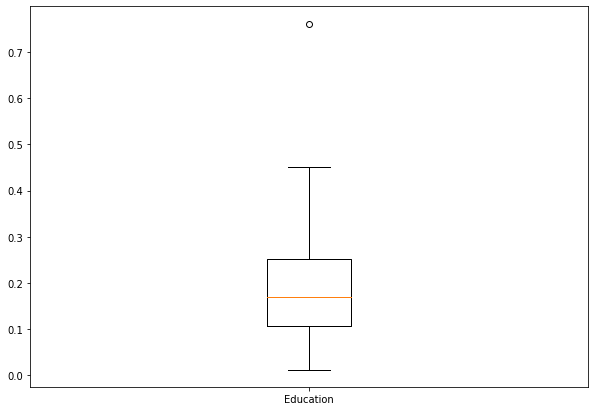

done for district Bangalore for category Education in time  1.3469195365905762


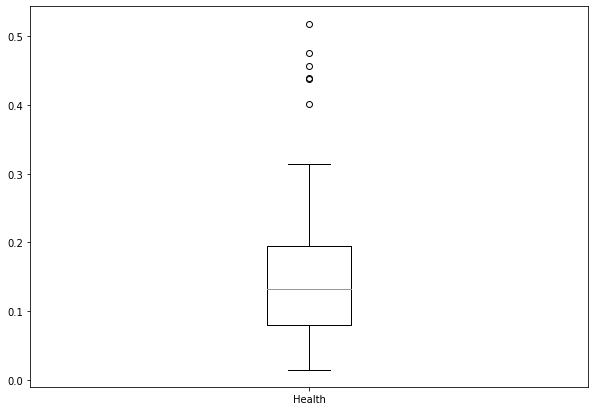

done for district Bangalore for category Health in time  0.5555384159088135


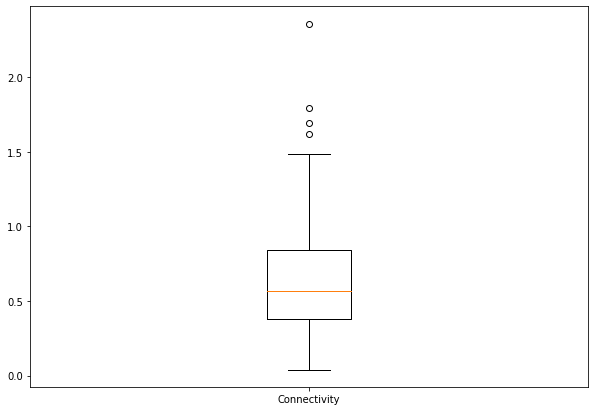

done for district Bangalore for category Connectivity in time  0.47497129440307617


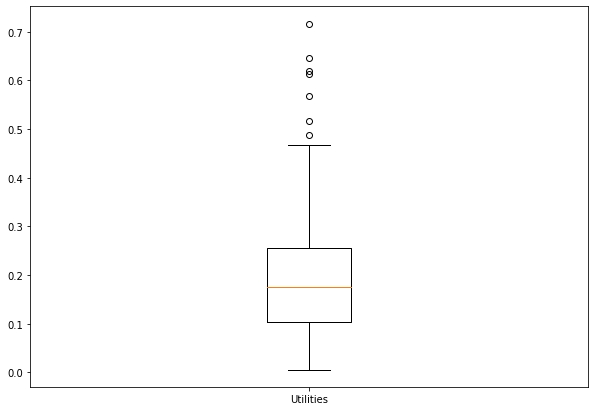

done for district Bangalore for category Utilities in time  0.4523923397064209


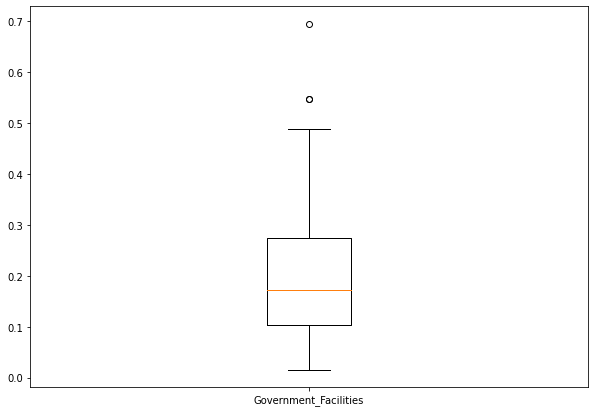

done for district Bangalore for category Government_Facilities in time  0.47698163986206055


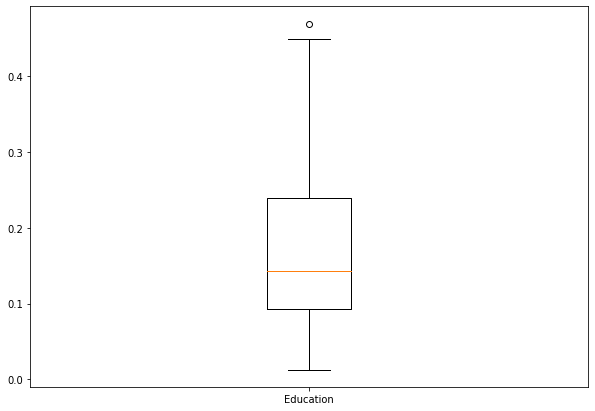

done for district Chennai for category Education in time  0.7697126865386963


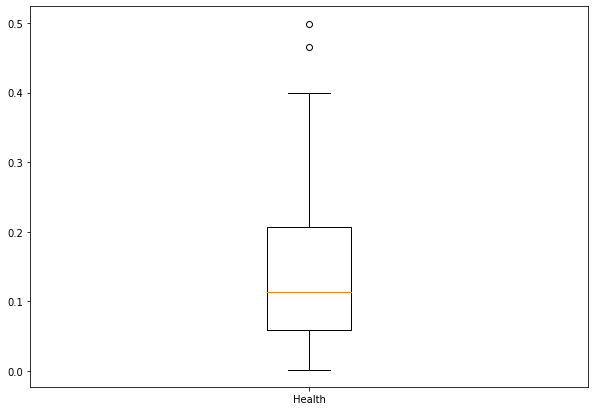

done for district Chennai for category Health in time  0.6415367126464844


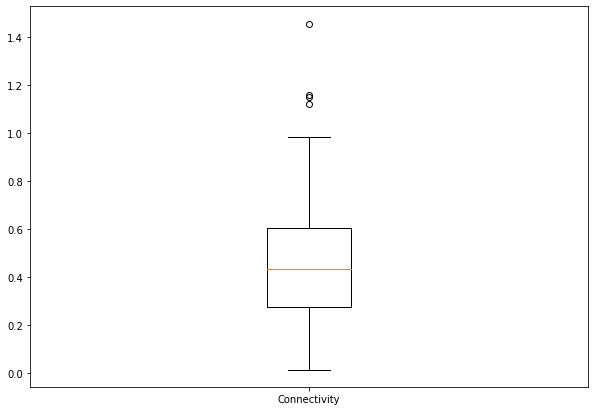

done for district Chennai for category Connectivity in time  0.5112001895904541


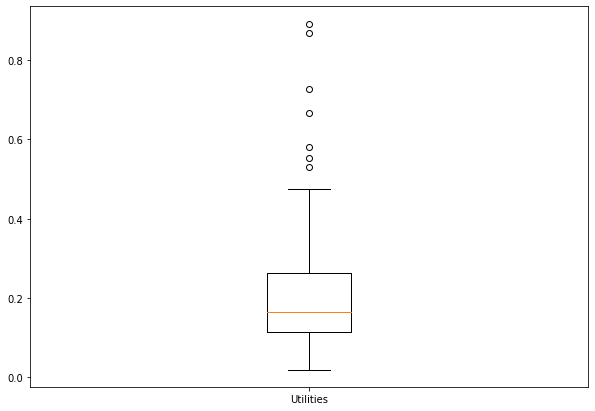

done for district Chennai for category Utilities in time  0.3598136901855469


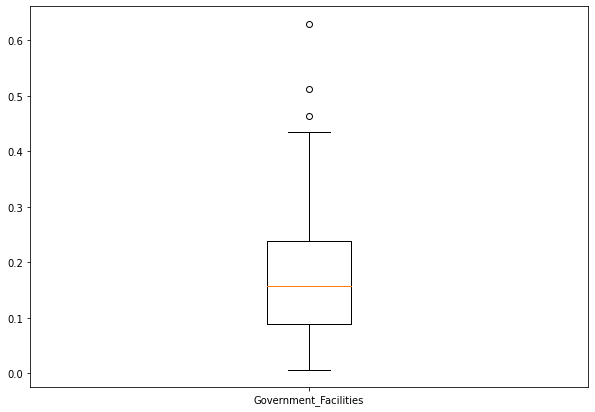

done for district Chennai for category Government_Facilities in time  0.3999967575073242


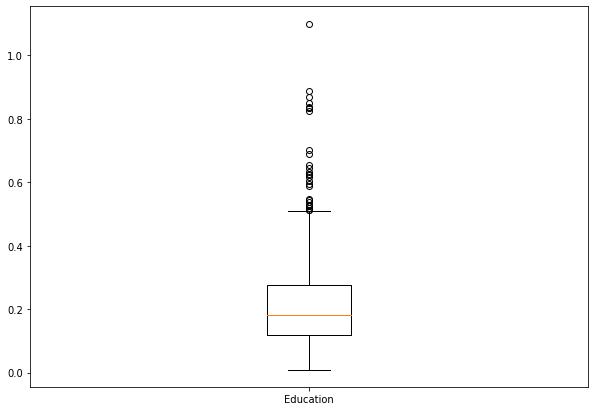

done for district Delhi for category Education in time  0.6495249271392822


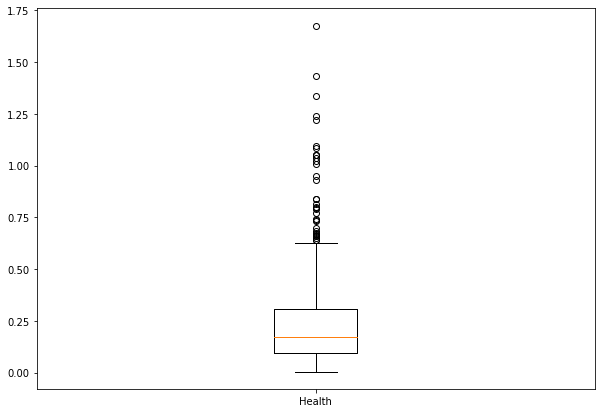

done for district Delhi for category Health in time  0.43641209602355957


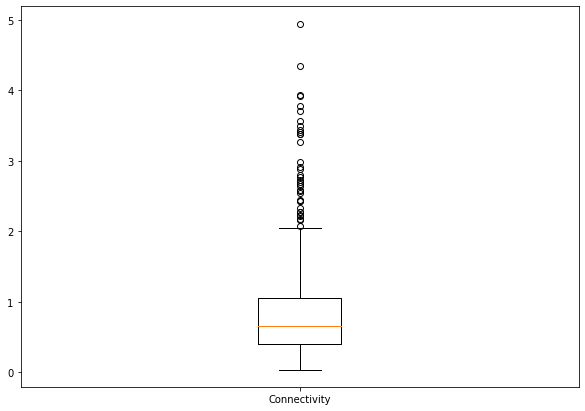

done for district Delhi for category Connectivity in time  0.5500690937042236


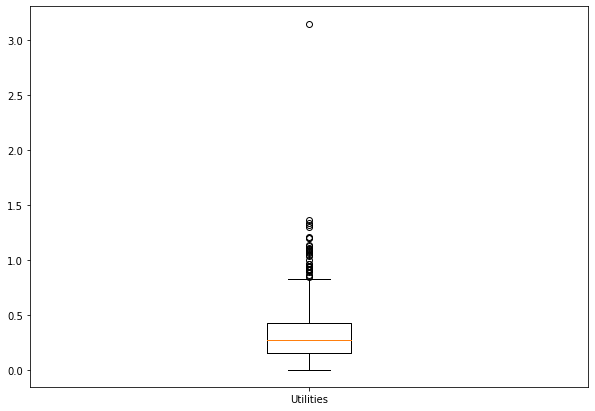

done for district Delhi for category Utilities in time  0.45180773735046387


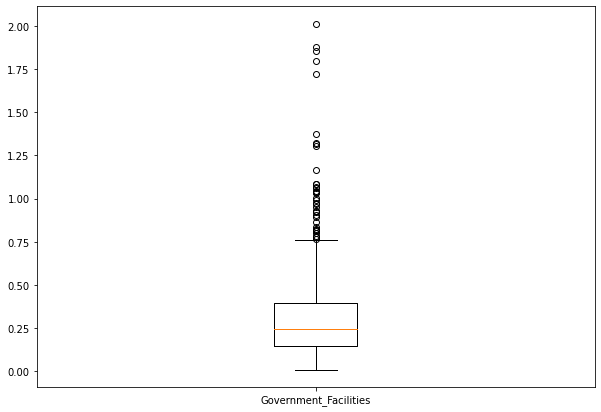

done for district Delhi for category Government_Facilities in time  0.5424036979675293


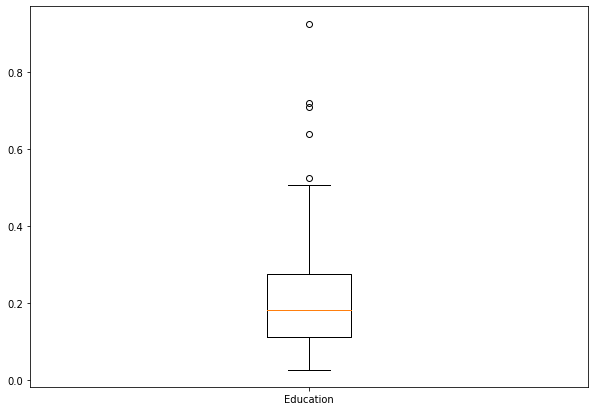

done for district Gurgaon for category Education in time  0.7677299976348877


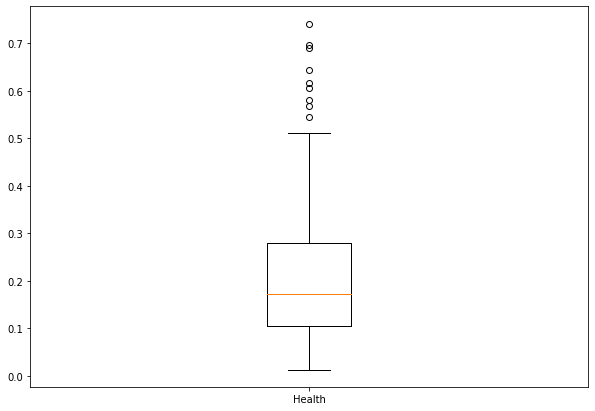

done for district Gurgaon for category Health in time  0.4619290828704834


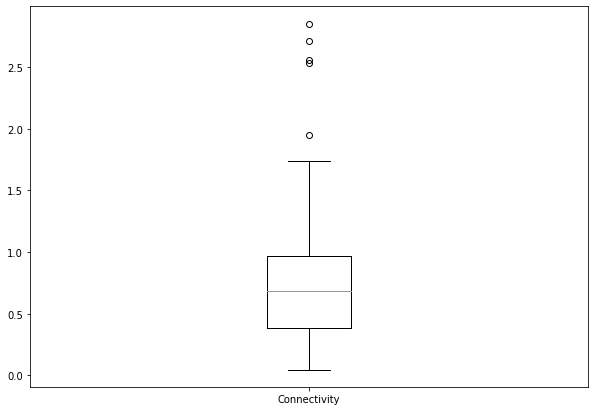

done for district Gurgaon for category Connectivity in time  0.46298646926879883


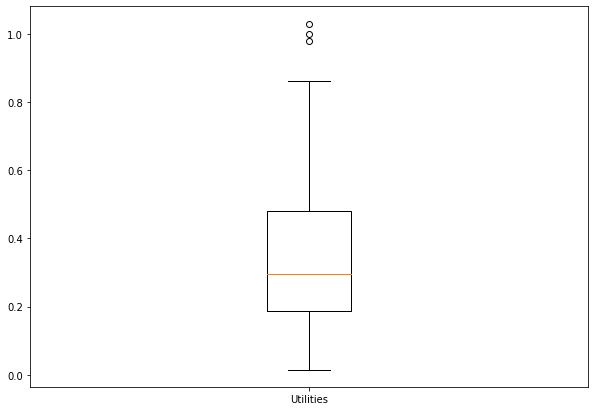

done for district Gurgaon for category Utilities in time  0.4790036678314209


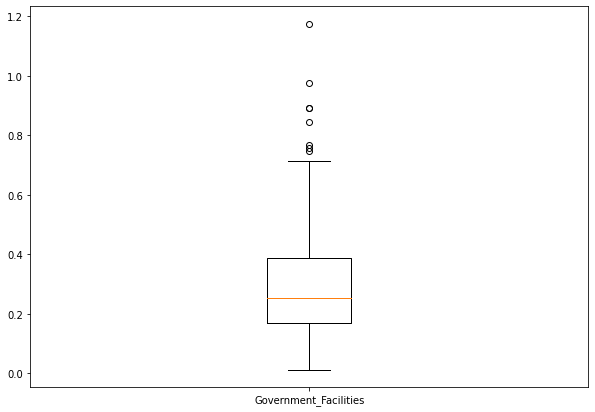

done for district Gurgaon for category Government_Facilities in time  0.4782543182373047


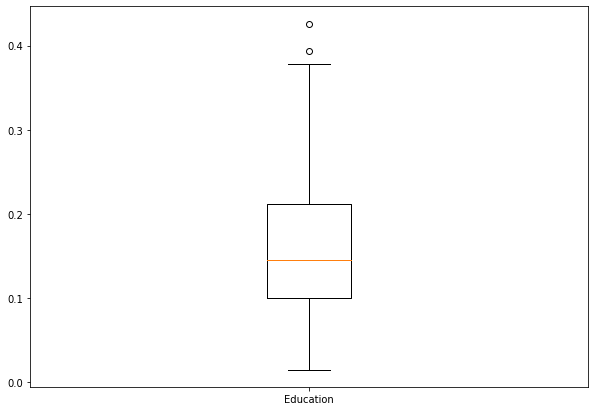

done for district Hyderabad for category Education in time  0.6930830478668213


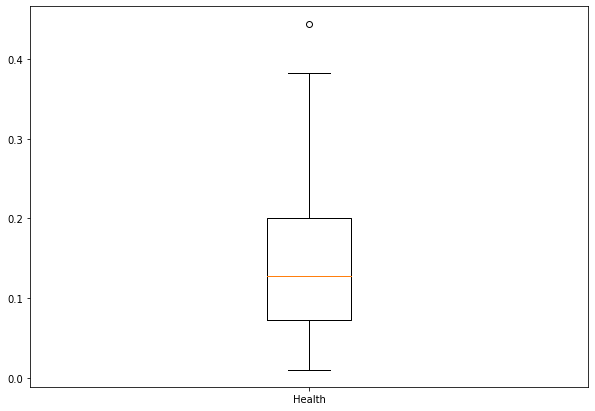

done for district Hyderabad for category Health in time  0.37887144088745117


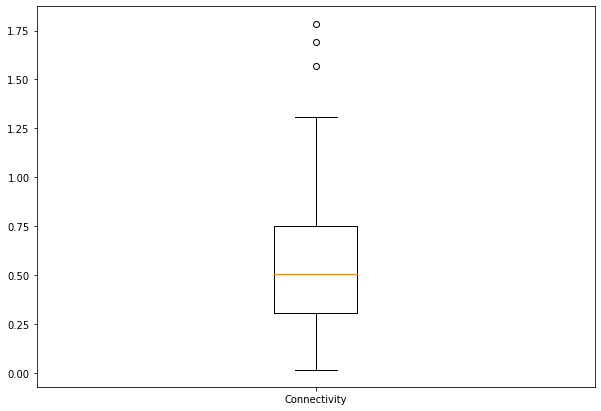

done for district Hyderabad for category Connectivity in time  0.3935365676879883


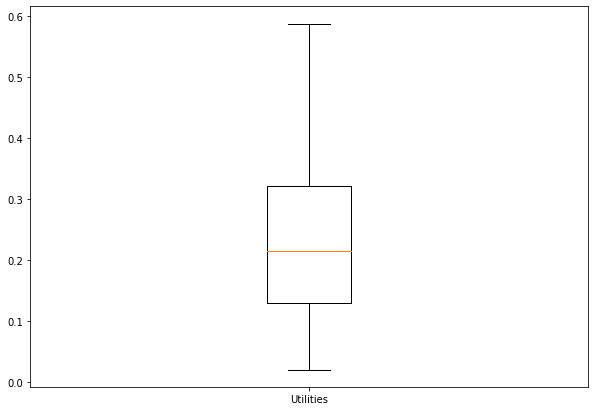

done for district Hyderabad for category Utilities in time  0.38848328590393066


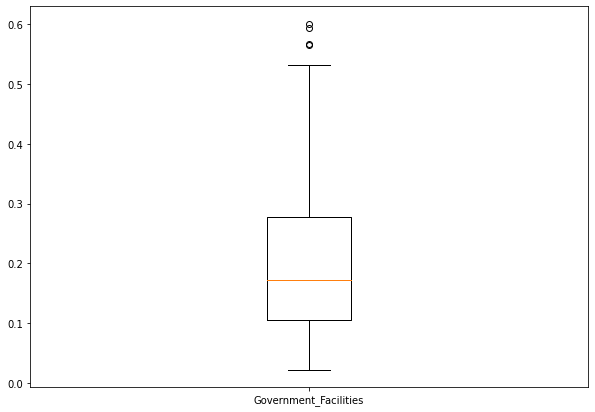

done for district Hyderabad for category Government_Facilities in time  0.3664076328277588


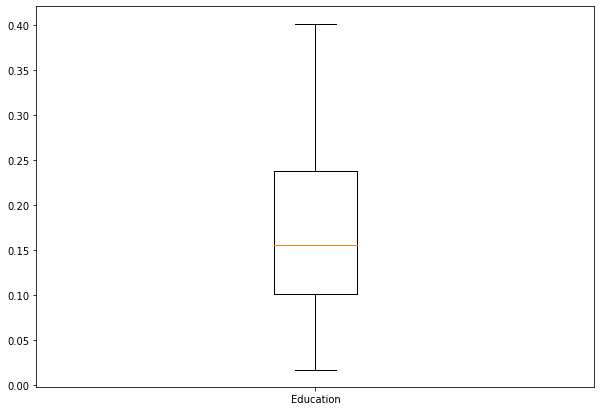

done for district Kolkata for category Education in time  0.671727180480957


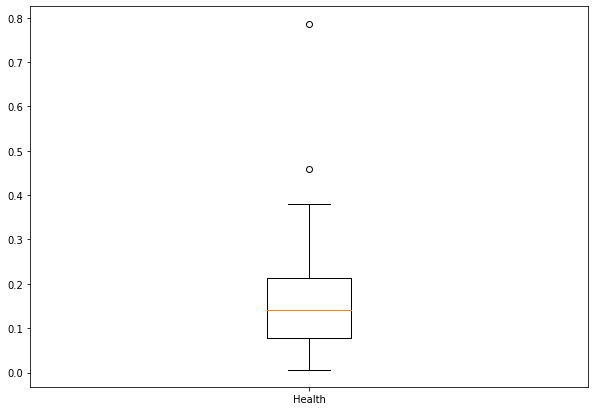

done for district Kolkata for category Health in time  0.3770163059234619


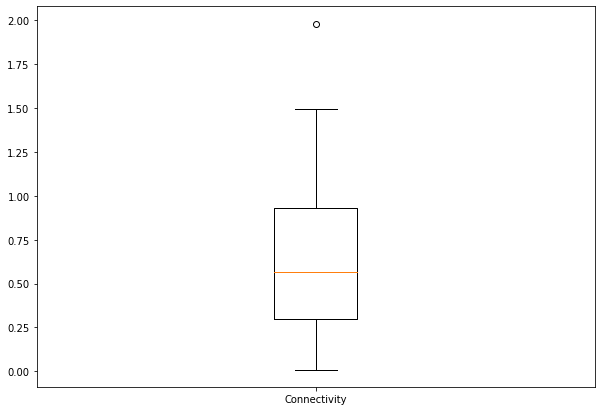

done for district Kolkata for category Connectivity in time  0.4018275737762451


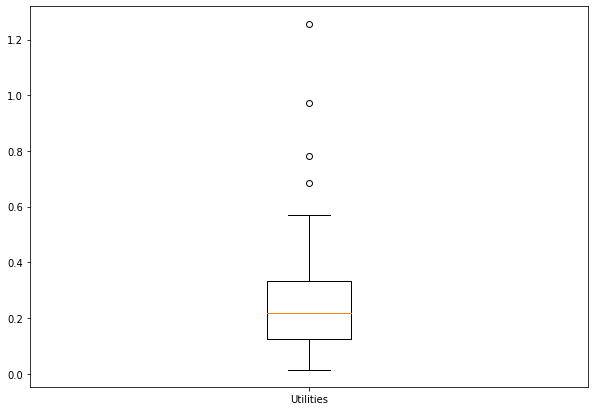

done for district Kolkata for category Utilities in time  0.3765592575073242


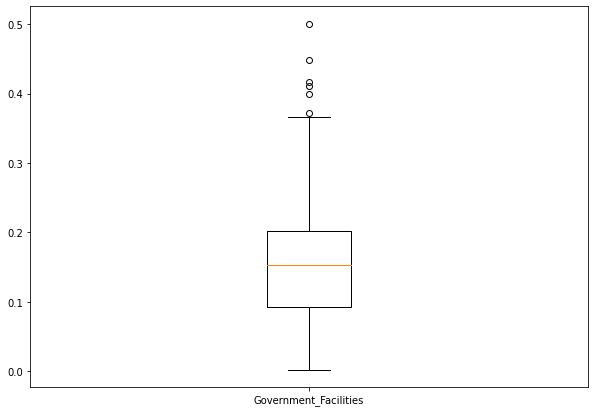

done for district Kolkata for category Government_Facilities in time  0.39816880226135254


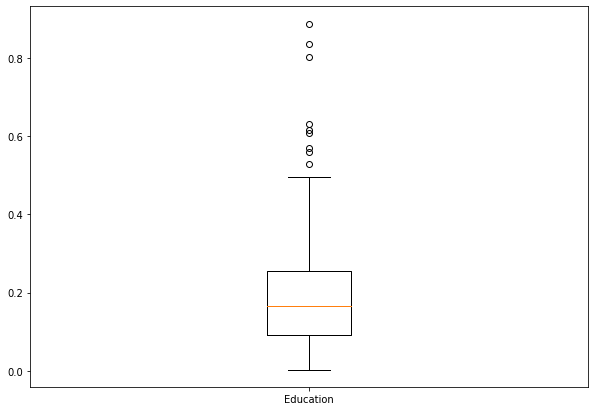

done for district Mumbai for category Education in time  0.15510797500610352


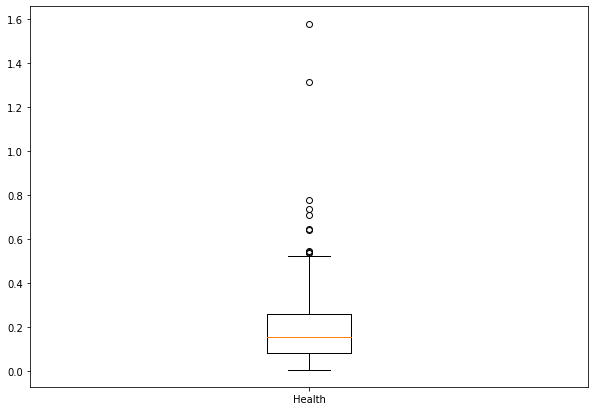

done for district Mumbai for category Health in time  0.5587589740753174


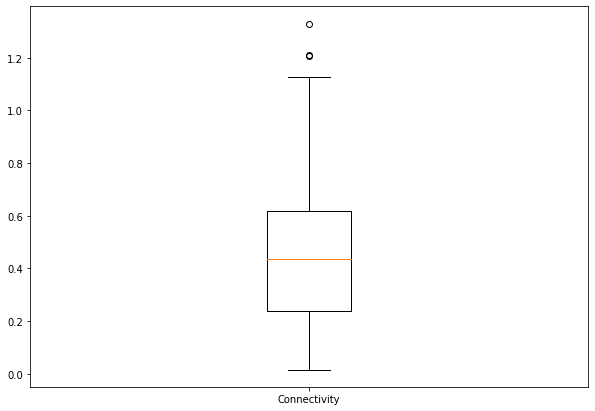

done for district Mumbai for category Connectivity in time  1.2812409400939941


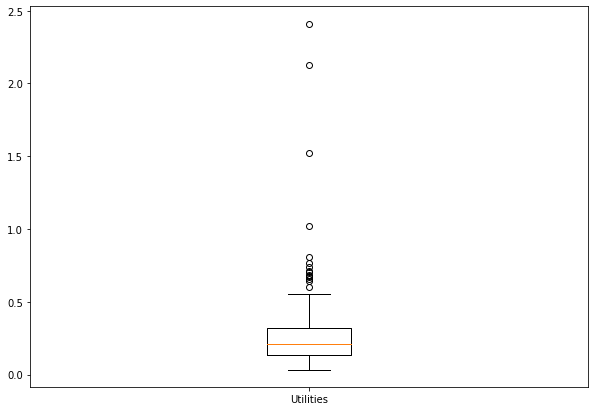

done for district Mumbai for category Utilities in time  0.45279788970947266


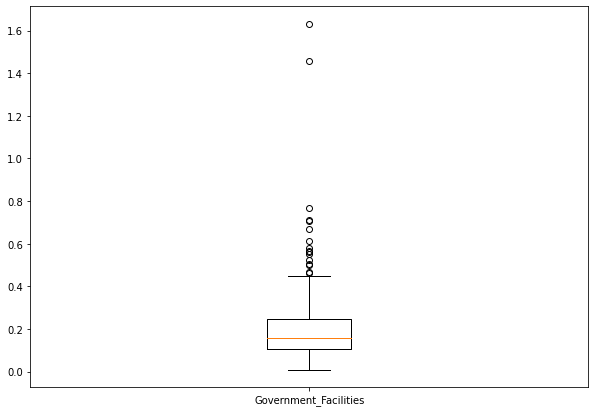

done for district Mumbai for category Government_Facilities in time  0.5020098686218262


In [ ]:
# districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
# category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
# for i in range(len(districts)):
#   for key in category_dict:
#     start_time=time.time()
#     category_dict[key].append(len(outliers_grid_number_for_nearest_amenity_indicator(districts[i],key,2019)))
#     print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
# data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
# df = pd.DataFrame(data, columns = data.keys())
# df.to_csv('Histogram_data_of_combined_grids_for_' + 'num_of_outliers_for_nearest_'+'category'+'_distance'+'.csv', index=False)

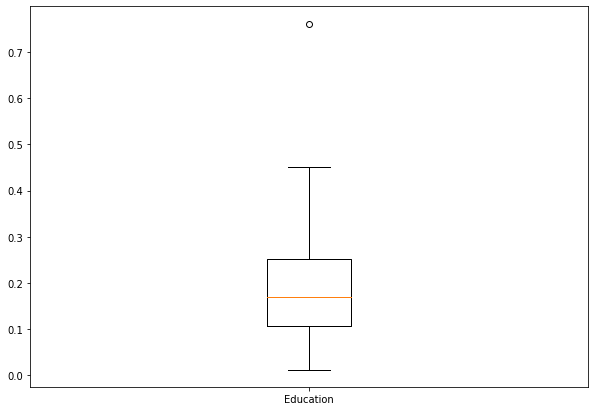

done for district Bangalore for category Education lat-lon=>  [12.775 77.63499999999999]


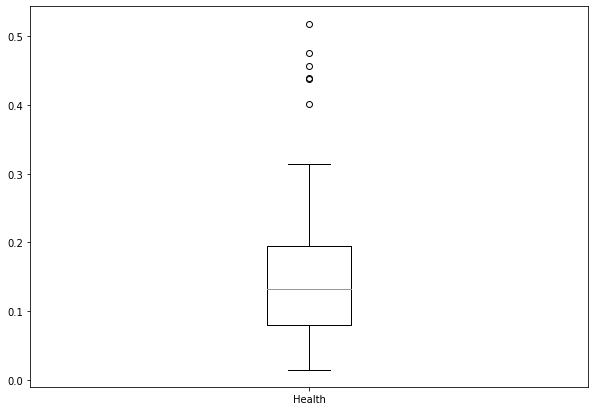

done for district Bangalore for category Health lat-lon=>  [12.775 77.63499999999999]


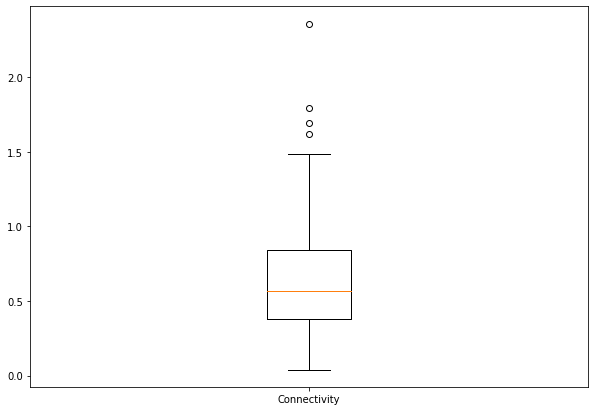

done for district Bangalore for category Connectivity lat-lon=>  [12.995000000000001 77.505]


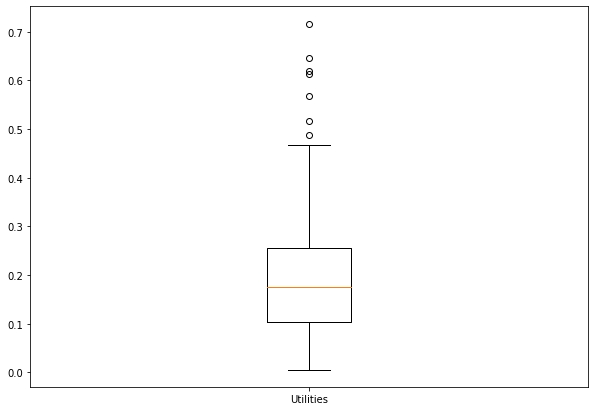

done for district Bangalore for category Utilities lat-lon=>  [12.775 77.63499999999999]


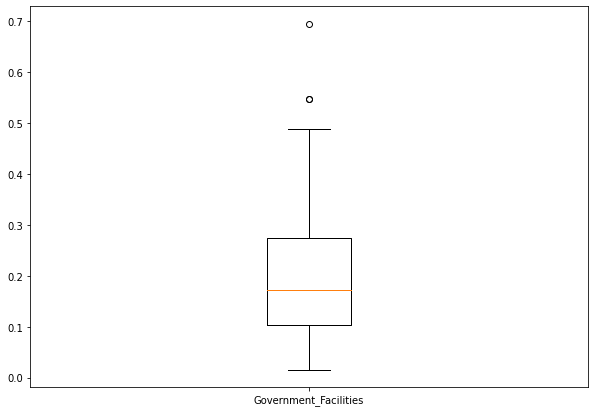

done for district Bangalore for category Government_Facilities lat-lon=>  [12.985000000000001 77.695]


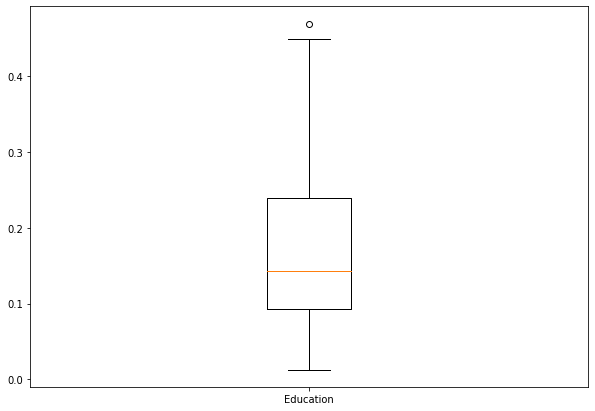

done for district Chennai for category Education lat-lon=>  [13.105 80.195]


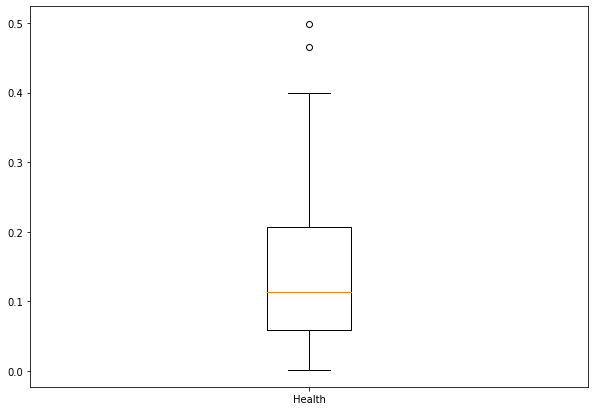

done for district Chennai for category Health lat-lon=>  [12.975000000000001 80.235]


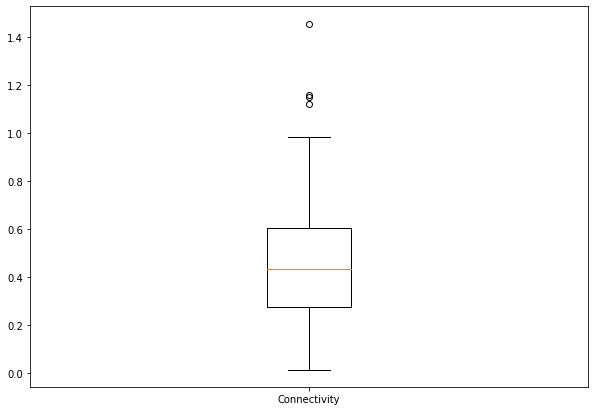

done for district Chennai for category Connectivity lat-lon=>  [13.075000000000001 80.185]


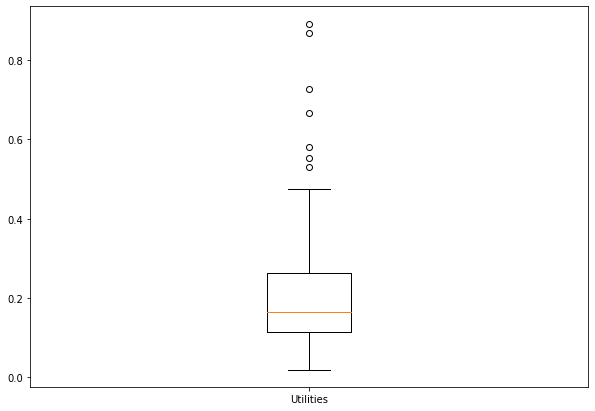

done for district Chennai for category Utilities lat-lon=>  [13.085 80.295]


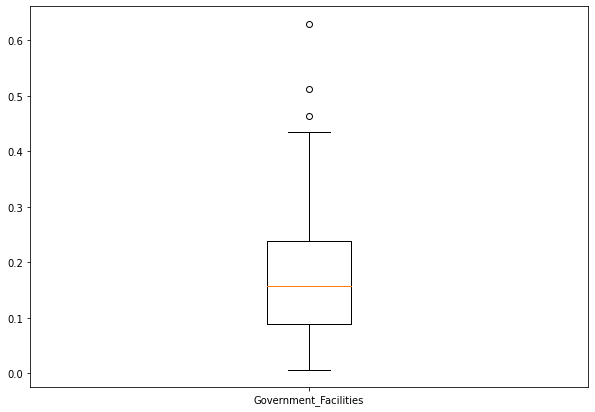

done for district Chennai for category Government_Facilities lat-lon=>  [12.975000000000001 80.235]


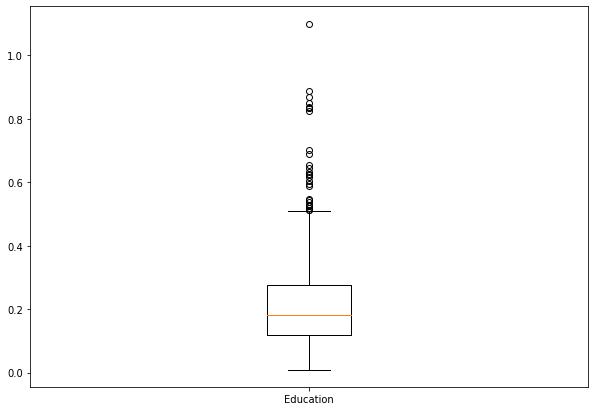

done for district Delhi for category Education lat-lon=>  [28.474999999999998 77.225]


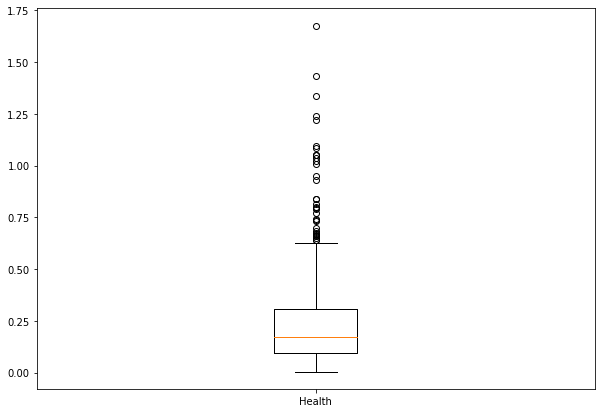

done for district Delhi for category Health lat-lon=>  [28.445 77.235]


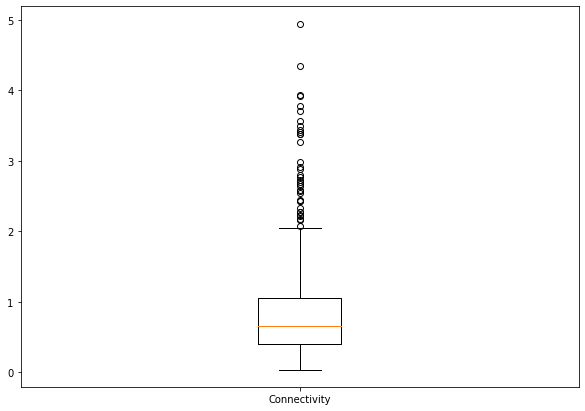

done for district Delhi for category Connectivity lat-lon=>  [28.445 77.235]


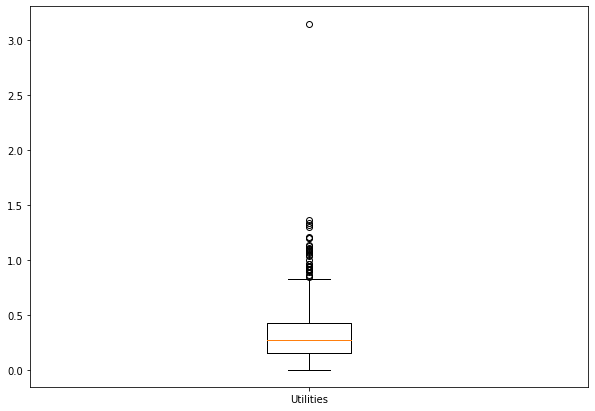

done for district Delhi for category Utilities lat-lon=>  [28.445 77.235]


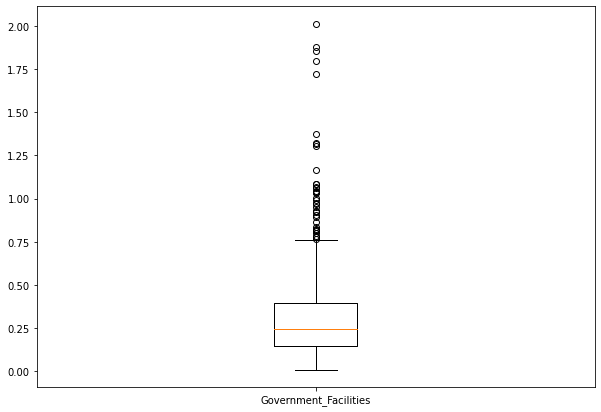

done for district Delhi for category Government_Facilities lat-lon=>  [28.814999999999998 77.125]


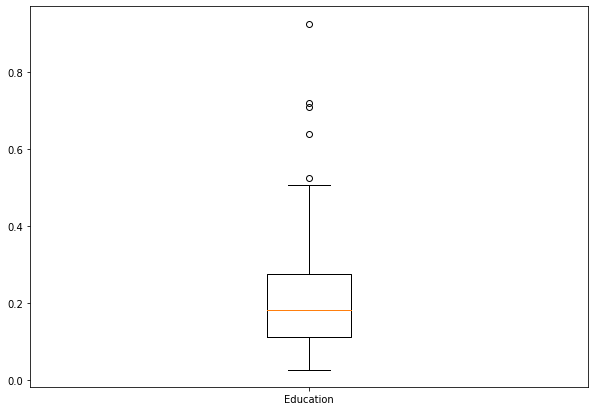

done for district Gurgaon for category Education lat-lon=>  [28.365 76.88499999999999]


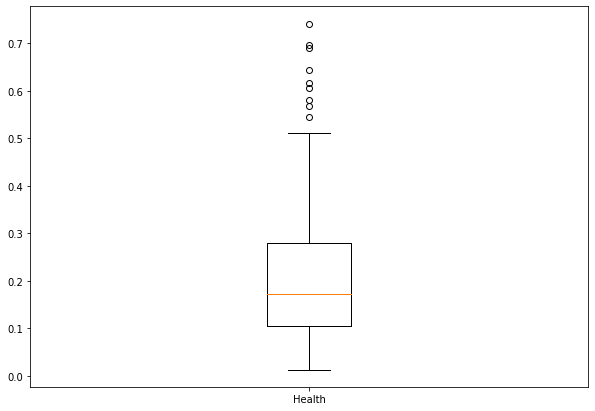

done for district Gurgaon for category Health lat-lon=>  [28.365 76.905]


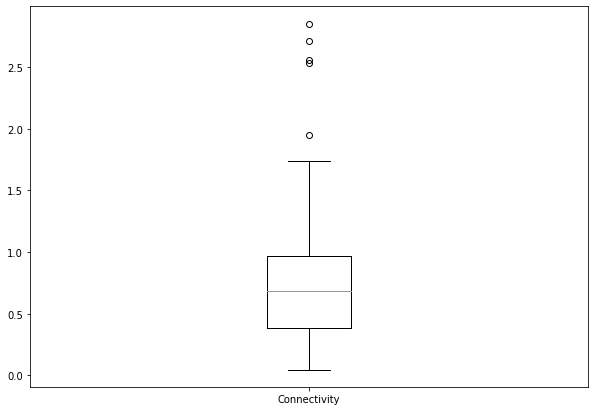

done for district Gurgaon for category Connectivity lat-lon=>  [28.375 76.91499999999999]


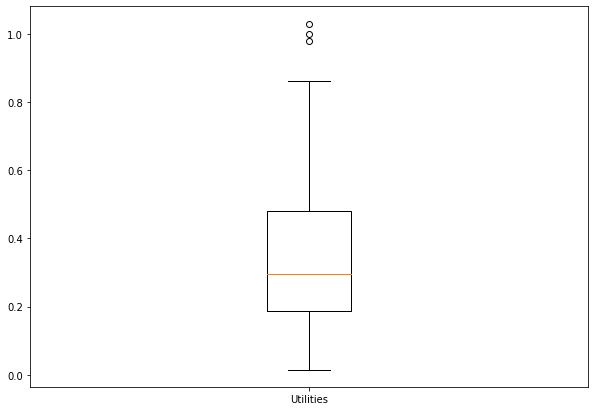

done for district Gurgaon for category Utilities lat-lon=>  [28.485 76.99499999999999]


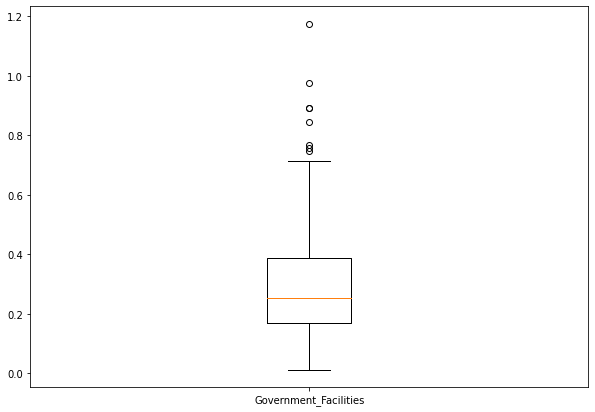

done for district Gurgaon for category Government_Facilities lat-lon=>  [28.395 77.065]


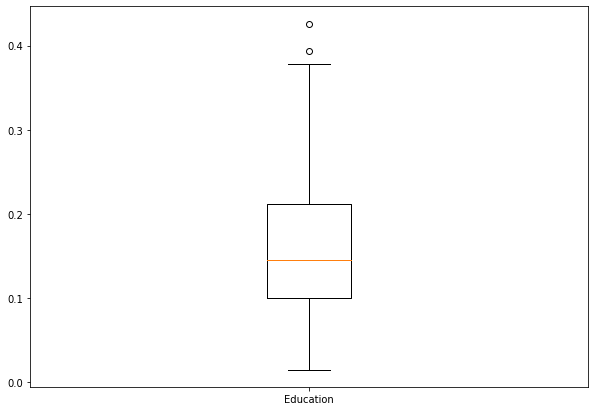

done for district Hyderabad for category Education lat-lon=>  [17.365 78.455]


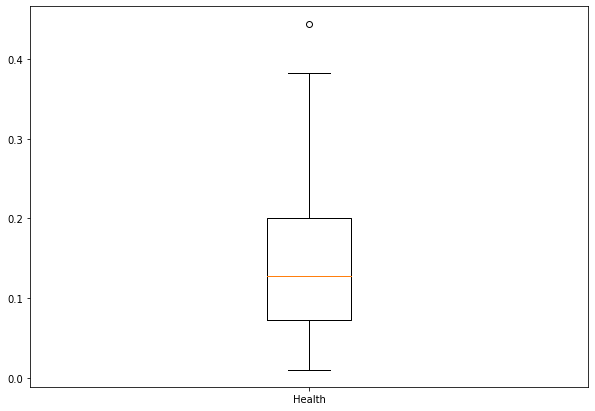

done for district Hyderabad for category Health lat-lon=>  [17.435 78.515]


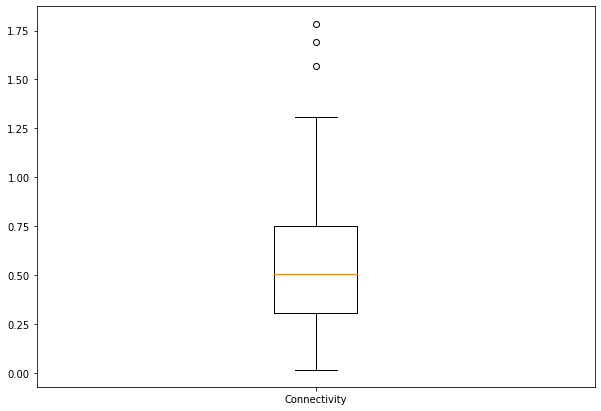

done for district Hyderabad for category Connectivity lat-lon=>  [17.375 78.455]


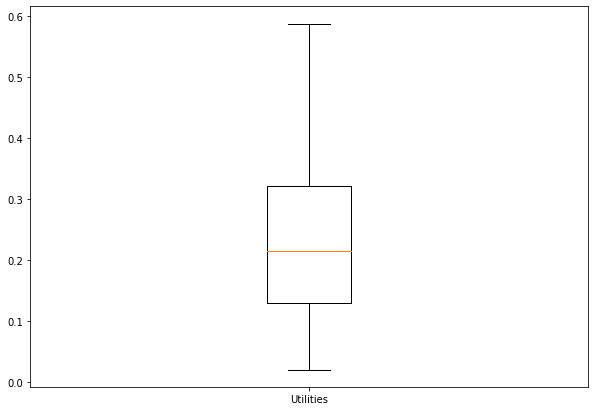

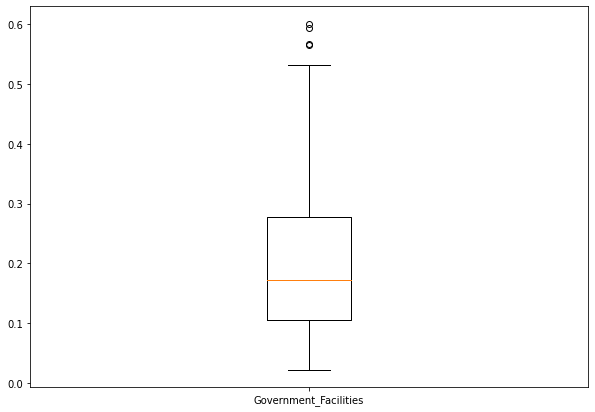

done for district Hyderabad for category Government_Facilities lat-lon=>  [17.384999999999998 78.41499999999999]


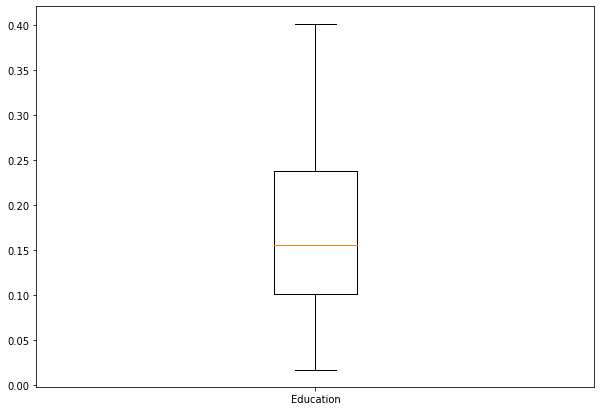

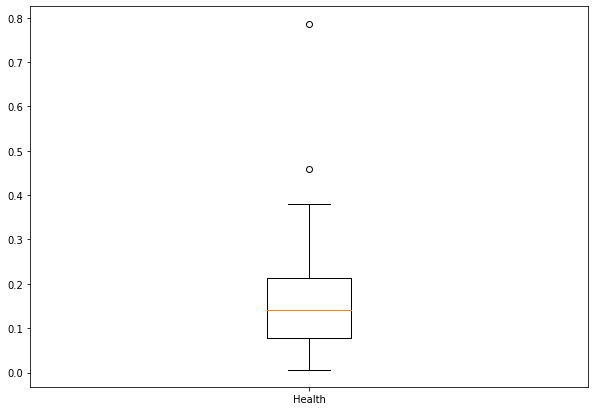

done for district Kolkata for category Health lat-lon=>  [22.525 88.30499999999999]


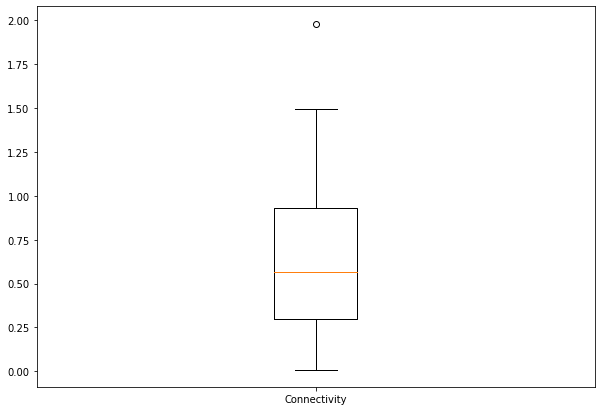

done for district Kolkata for category Connectivity lat-lon=>  [22.555 88.38499999999999]


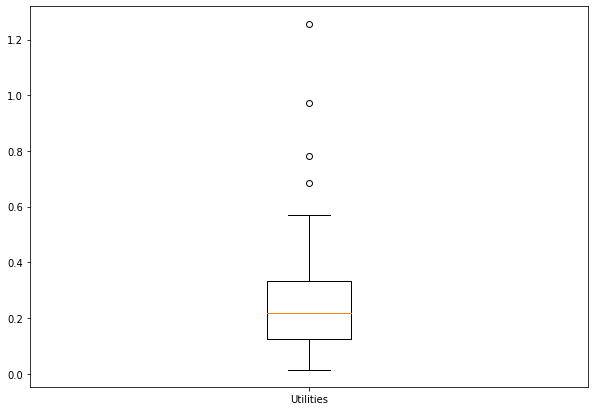

done for district Kolkata for category Utilities lat-lon=>  [22.535 88.30499999999999]


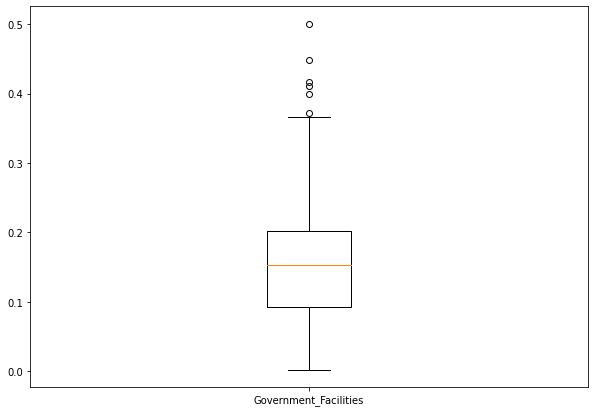

done for district Kolkata for category Government_Facilities lat-lon=>  [22.525 88.315]


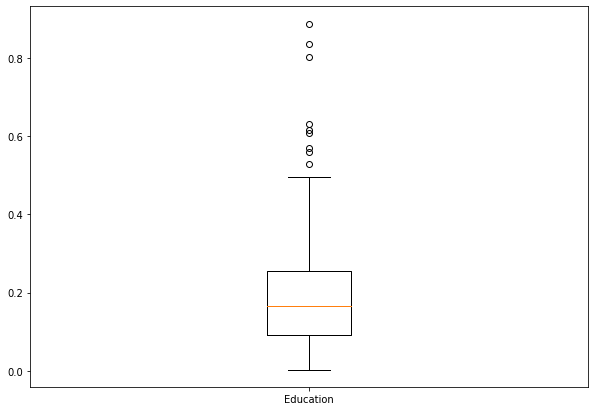

done for district Mumbai for category Education lat-lon=>  [19.005 72.895]


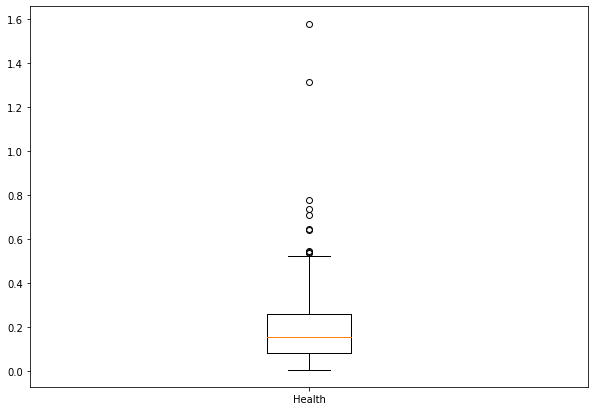

done for district Mumbai for category Health lat-lon=>  [19.005 72.905]


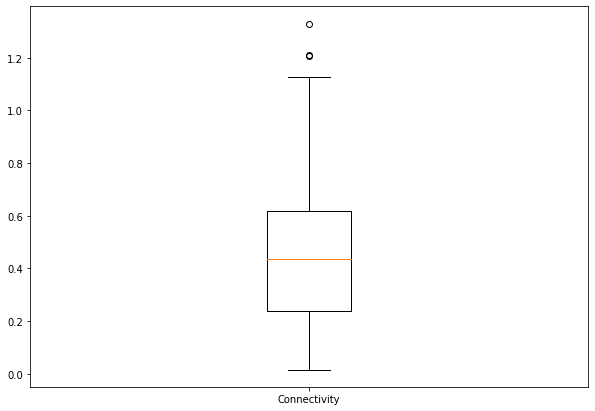

done for district Mumbai for category Connectivity lat-lon=>  [19.075 72.82499999999999]


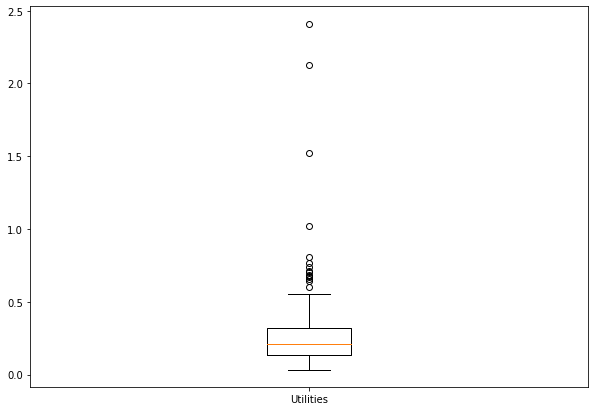

done for district Mumbai for category Utilities lat-lon=>  [19.005 72.895]


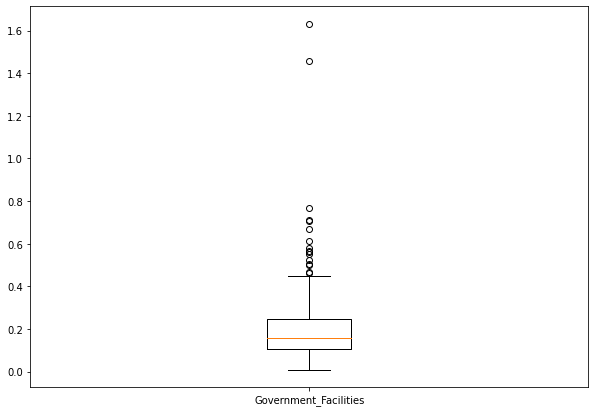

done for district Mumbai for category Government_Facilities lat-lon=>  [19.005 72.905]


In [ ]:
# districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
# category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
# for i in range(len(districts)):
#   for key in category_dict:
#     start_time=time.time()
#     district_name=districts[i]
#     category_name=key
#     year=2019
#     filename = district_name + '_nearest_'+category_name+'_from_each_grid_centre.csv'
#     grids_info=get_grid_info(district_name,year)
#     num_arr=pd.read_csv(filename)
#     num_arr=num_arr.to_numpy()
#     num_arr = num_arr[:,1] 
#     grid_num=np.arange(num_arr.shape[0])
#     combined_grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
#     combined_grids_dist=num_arr[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
#     fig = plt.figure(figsize =(10, 7)) 
#     # Creating plot
#     bp=plt.boxplot(combined_grids_dist, labels=[category_name])
#     # show plot 
#     plt.show()
#     amenity_outlier=(np.array(bp['fliers'][0].get_data()[1]))
#     # print(amenity_outlier)
#     amenity_index=np.in1d(combined_grids_dist,amenity_outlier)
#     # print(amenity_index)
#     outlier_grid_numbers=combined_grid_num[amenity_index]
#     # print(outlier_grid_numbers)
#     # print(amenity_outlier)
#     outliers_lat_lon=grids_info[:,1:3][outlier_grid_numbers]
#     # print(outliers_lat_lon)
#     if (len(amenity_outlier)==0):
#       pass
#     else:
#       imp_lat_lon=outliers_lat_lon[np.argmax(amenity_outlier)]
#       print('done for district '+districts[i]+' for category '+key+' lat-lon=> ', imp_lat_lon)

In [ ]:
def outliers_grid_percentage_for_nearest_amenity_indicator(district_name,category_name,year):
  filename = district_name + '_nearest_'+category_name+'_from_each_grid_centre.csv'
  grids_info=get_grid_info(district_name,year)
  num_arr=pd.read_csv(filename)
  num_arr=num_arr.to_numpy()
  num_arr = num_arr[:,1] 
  grid_num=np.arange(num_arr.shape[0])
  combined_grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  combined_grids_dist=num_arr[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  fig = plt.figure(figsize =(10, 7)) 
  # Creating plot
  bp=plt.boxplot(combined_grids_dist, labels=[category_name])
  # show plot 
  plt.show()
  amenity_outlier=(np.array(bp['fliers'][0].get_data()[1]))
  # print(amenity_outlier)
  amenity_index=np.in1d(combined_grids_dist,amenity_outlier)
  # print(amenity_index)
  outlier_grid_numbers=combined_grid_num[amenity_index]
  outlier_grid_percentage=(len(outlier_grid_numbers)/len(combined_grid_num))*(100)
  # print(outlier_grid_numbers)
  return outlier_grid_percentage

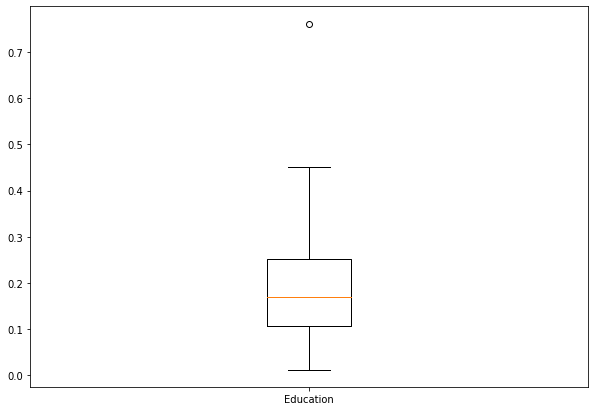

done for district Bangalore for category Education in time  0.9436948299407959


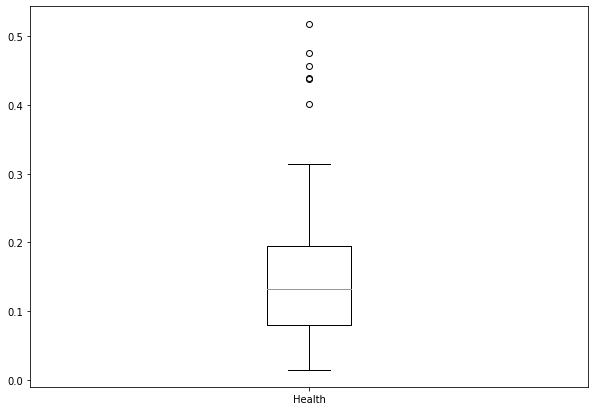

done for district Bangalore for category Health in time  0.4892914295196533


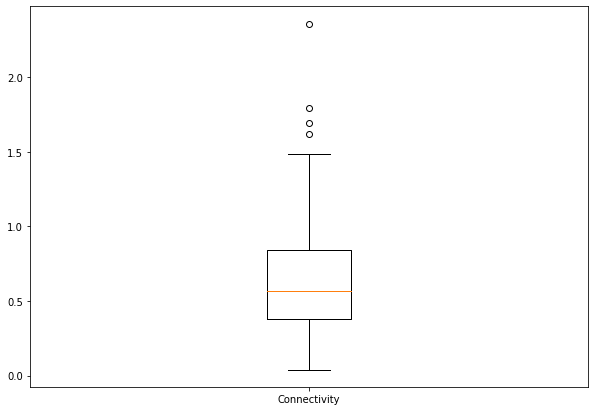

done for district Bangalore for category Connectivity in time  0.45788097381591797


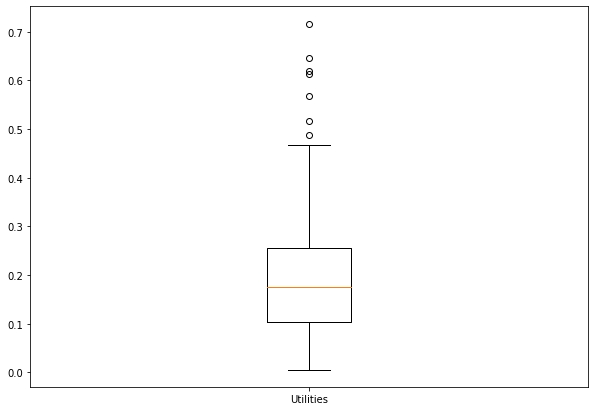

done for district Bangalore for category Utilities in time  0.47472262382507324


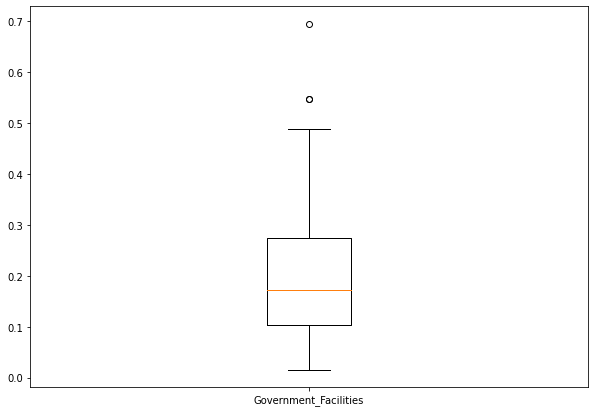

done for district Bangalore for category Government_Facilities in time  0.4817652702331543


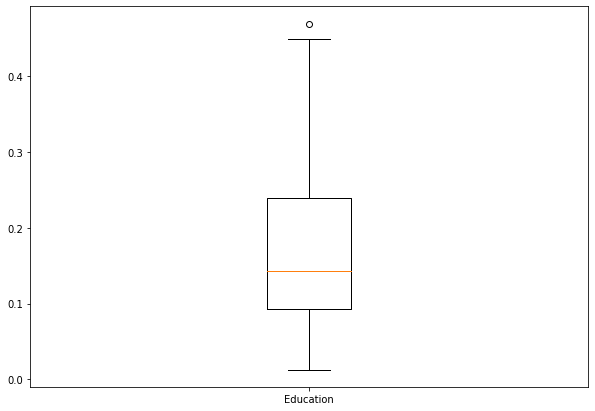

done for district Chennai for category Education in time  0.7800261974334717


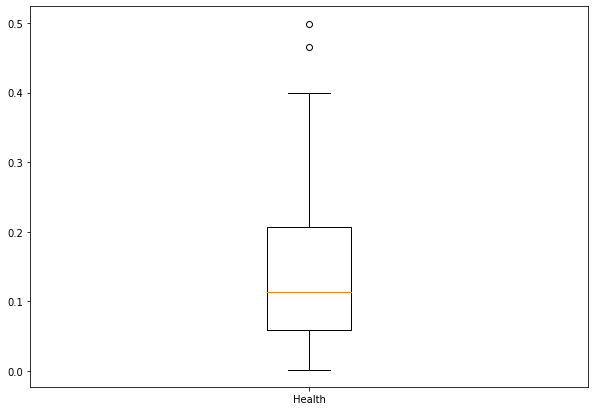

done for district Chennai for category Health in time  0.45113325119018555


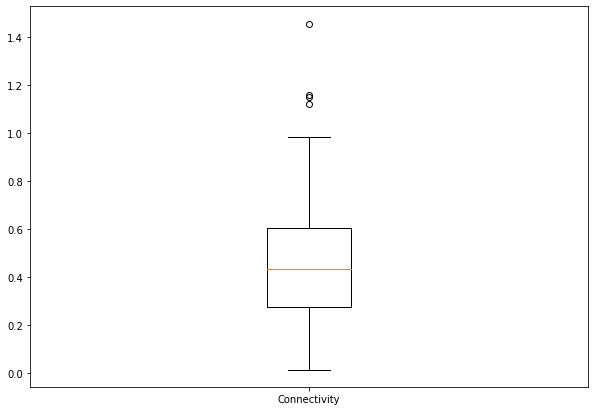

done for district Chennai for category Connectivity in time  0.4673483371734619


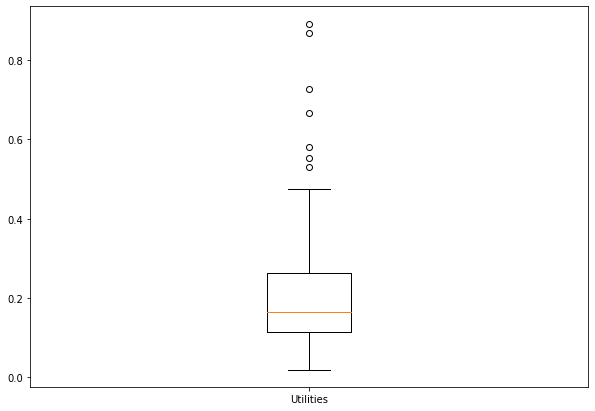

done for district Chennai for category Utilities in time  0.37913036346435547


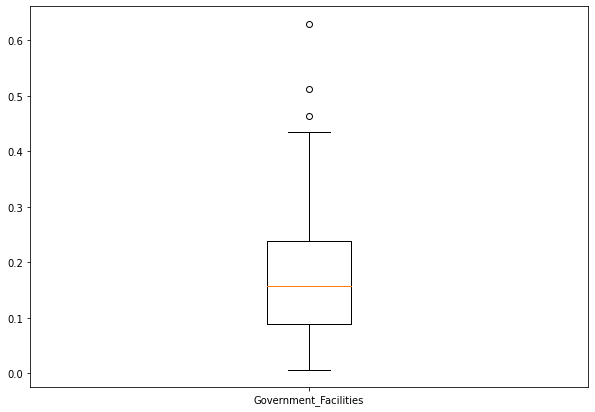

done for district Chennai for category Government_Facilities in time  0.46649980545043945


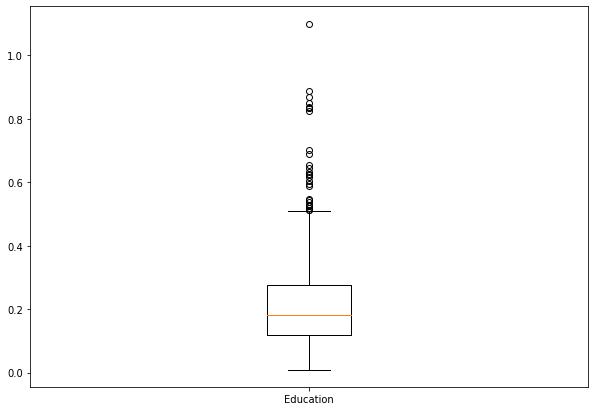

done for district Delhi for category Education in time  0.842268705368042


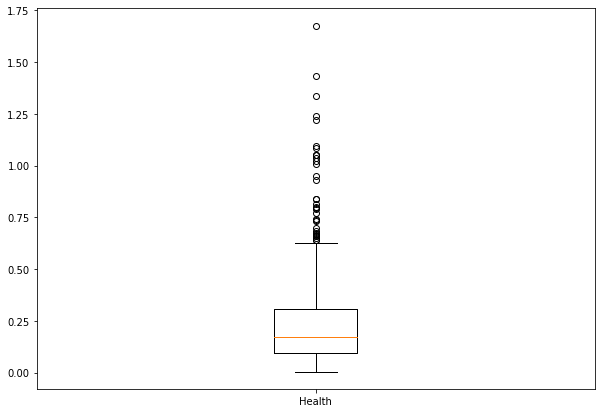

done for district Delhi for category Health in time  0.4566977024078369


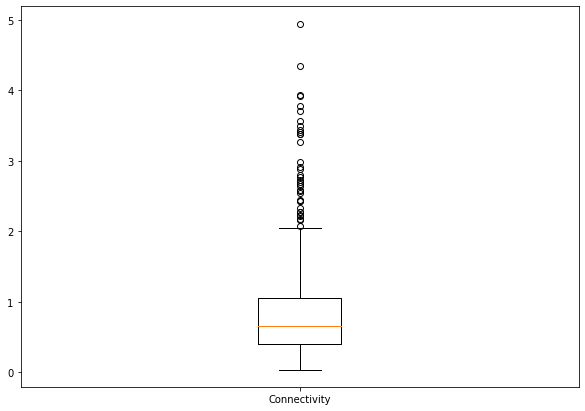

done for district Delhi for category Connectivity in time  0.48573780059814453


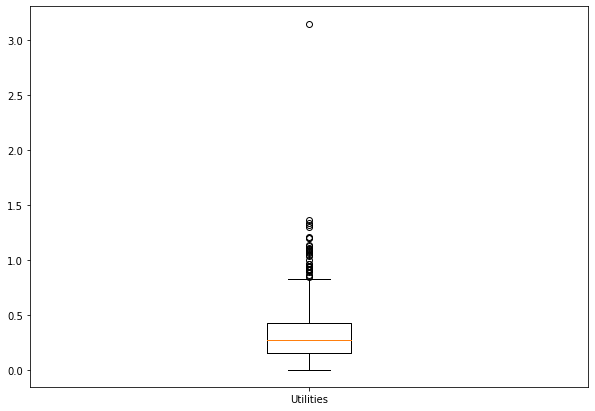

done for district Delhi for category Utilities in time  0.4434549808502197


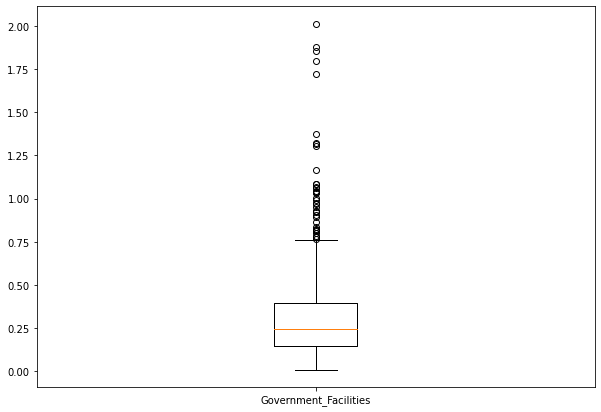

done for district Delhi for category Government_Facilities in time  0.49442410469055176


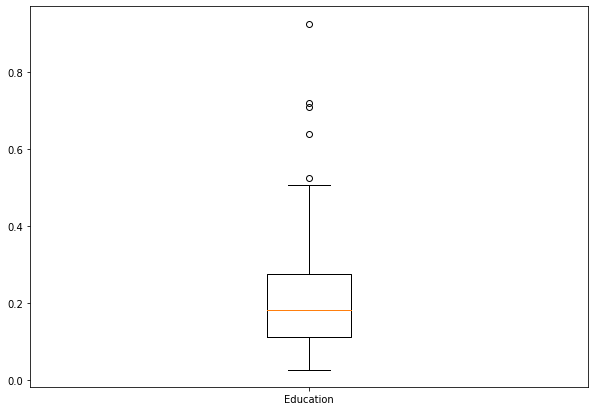

done for district Gurgaon for category Education in time  0.7966442108154297


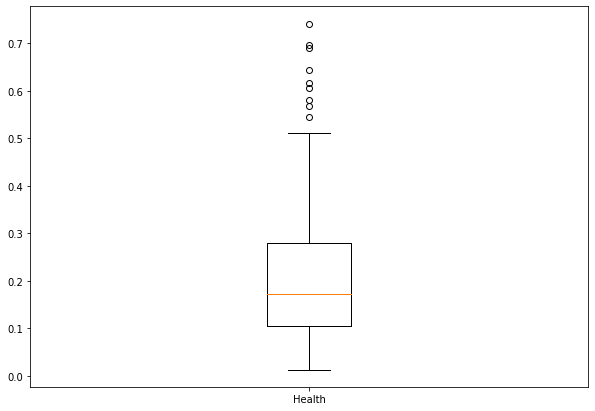

done for district Gurgaon for category Health in time  0.45873260498046875


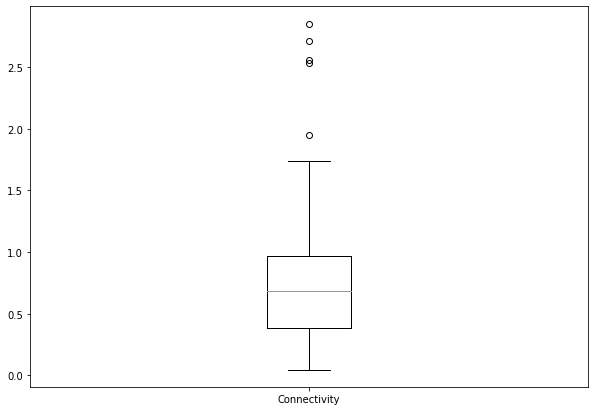

done for district Gurgaon for category Connectivity in time  0.45682525634765625


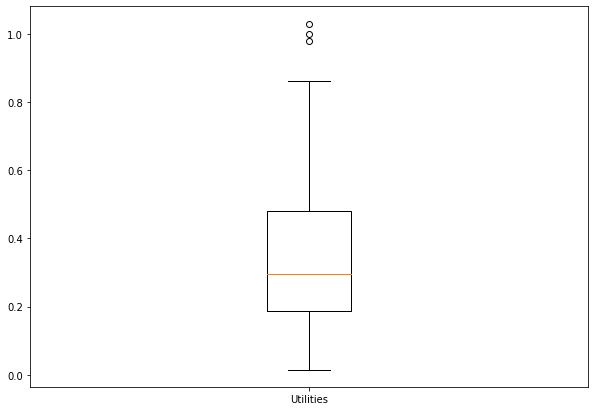

done for district Gurgaon for category Utilities in time  0.46251964569091797


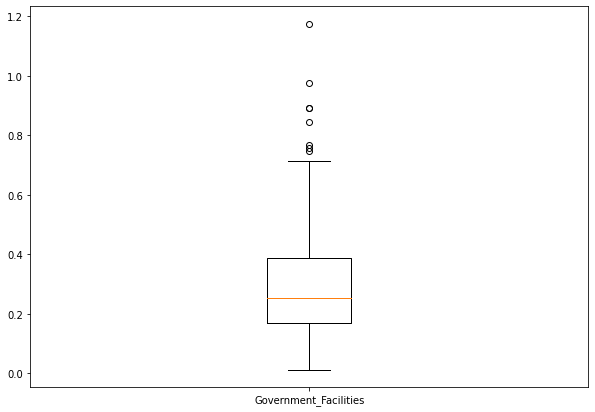

done for district Gurgaon for category Government_Facilities in time  0.5317261219024658


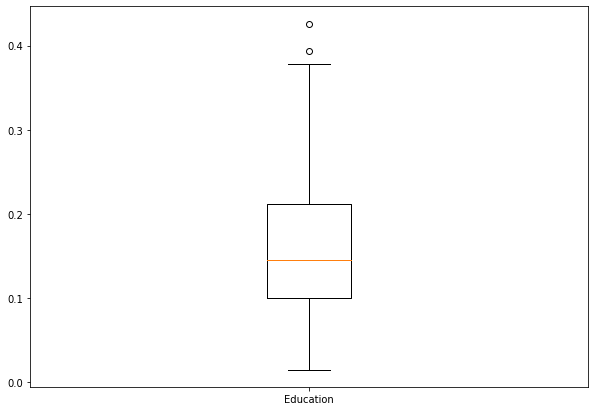

done for district Hyderabad for category Education in time  0.7395131587982178


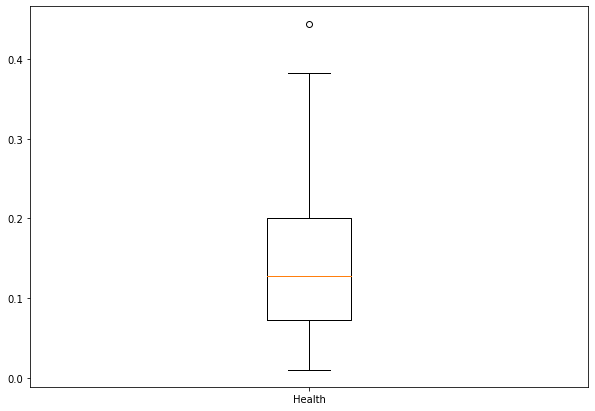

done for district Hyderabad for category Health in time  0.49618983268737793


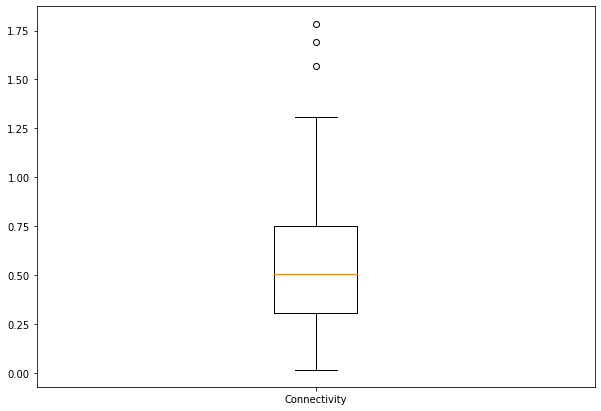

done for district Hyderabad for category Connectivity in time  0.458662748336792


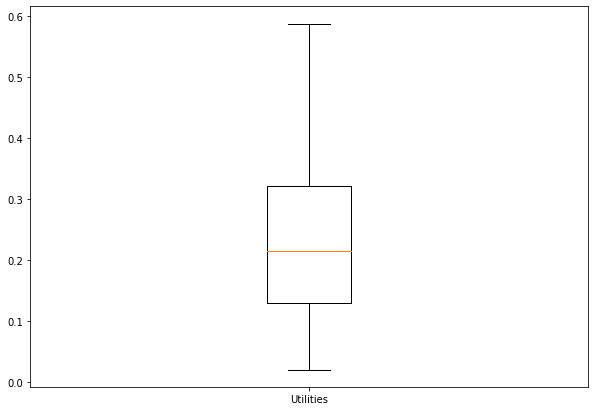

done for district Hyderabad for category Utilities in time  0.36762237548828125


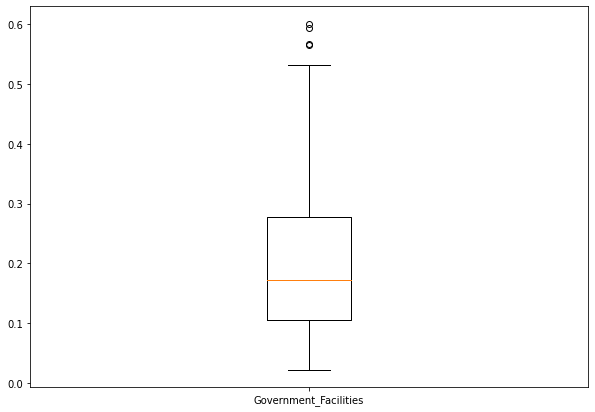

done for district Hyderabad for category Government_Facilities in time  0.4130673408508301


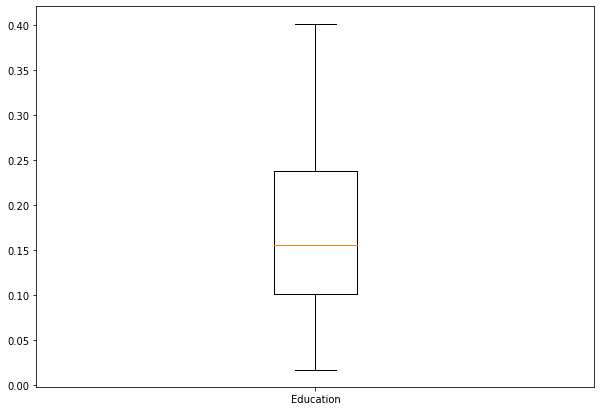

done for district Kolkata for category Education in time  0.7202622890472412


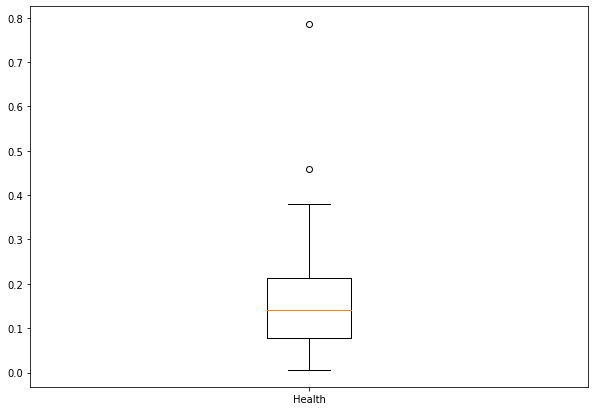

done for district Kolkata for category Health in time  0.38738131523132324


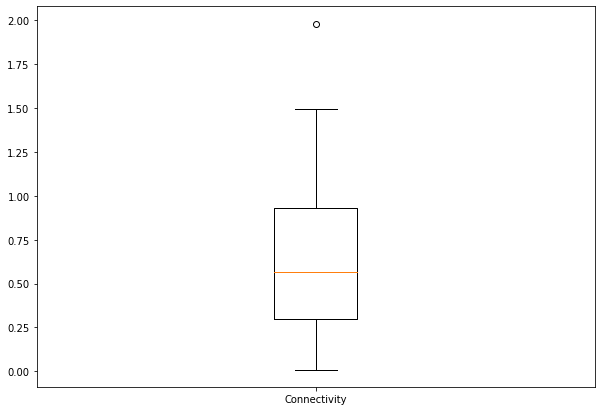

done for district Kolkata for category Connectivity in time  0.40427708625793457


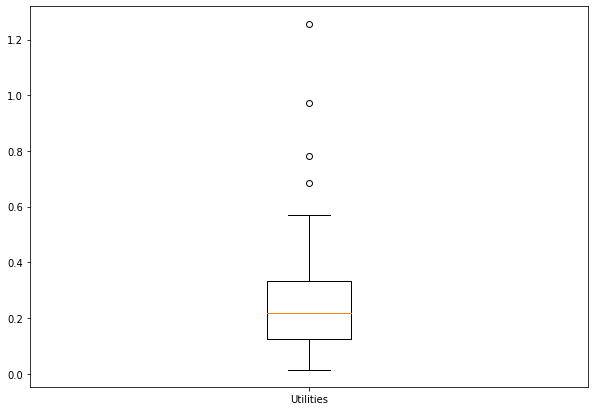

done for district Kolkata for category Utilities in time  0.44822239875793457


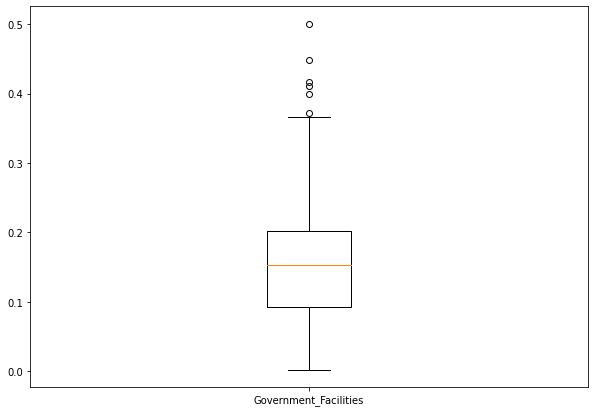

done for district Kolkata for category Government_Facilities in time  0.3607299327850342


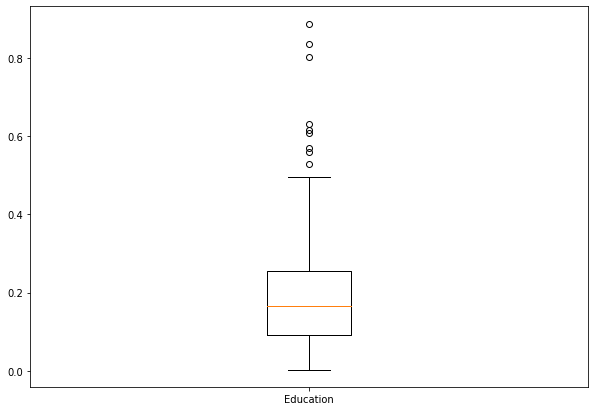

done for district Mumbai for category Education in time  0.6231615543365479


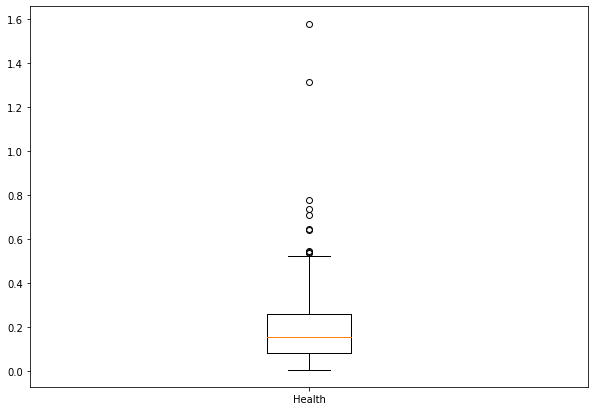

done for district Mumbai for category Health in time  0.40030574798583984


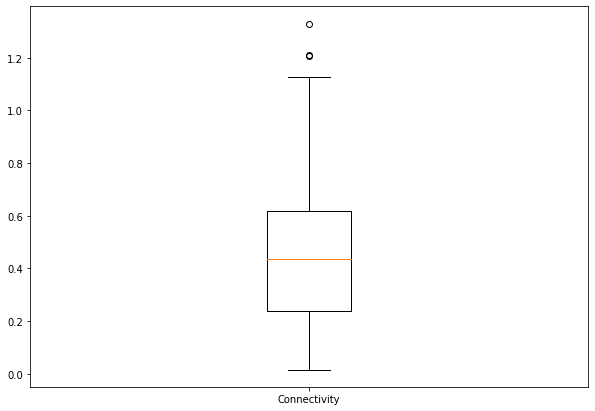

done for district Mumbai for category Connectivity in time  0.49083924293518066


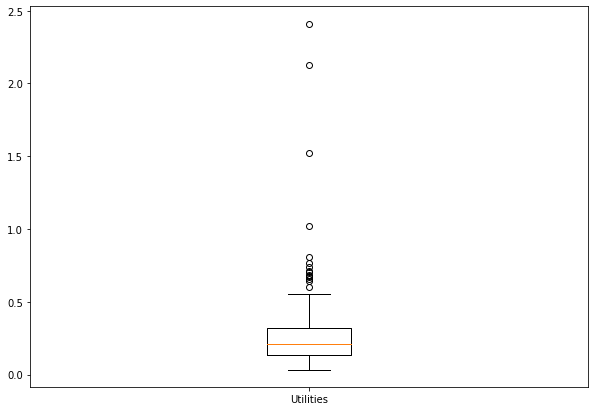

done for district Mumbai for category Utilities in time  0.42830562591552734


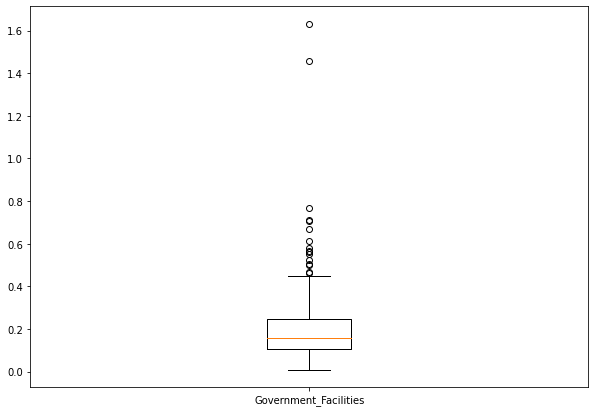

done for district Mumbai for category Government_Facilities in time  0.4046657085418701


In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
for i in range(len(districts)):
  for key in category_dict:
    start_time=time.time()
    category_dict[key].append(outliers_grid_percentage_for_nearest_amenity_indicator(districts[i],key,2019))
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Histogram_data_of_combined_grids_for_' + 'percentage_of_outlier_grids_for_nearest_'+'category'+'_distance'+'.csv', index=False)

In [ ]:
def outliers_cx_grid_count_list_for_nearest_amenity_indicator(district_name,category_name,year):
  filename = district_name + '_nearest_'+category_name+'_from_each_grid_centre.csv'
  grids_info=get_grid_info(district_name,year)
  num_arr=pd.read_csv(filename)
  num_arr=num_arr.to_numpy()
  num_arr = num_arr[:,1] 
  grid_num=np.arange(num_arr.shape[0])
  combined_grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  combined_grids_dist=num_arr[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  fig = plt.figure(figsize =(10, 7)) 
  # Creating plot
  bp=plt.boxplot(combined_grids_dist, labels=[category_name], showfliers=True, showcaps=True, showmeans=True)
  # show plot 
  plt.show()
  amenity_outlier=(np.array(bp['fliers'][0].get_data()[1]))
  # print(amenity_outlier)
  amenity_index=np.in1d(combined_grids_dist,amenity_outlier)
  # print(amenity_index)
  outlier_grid_numbers=combined_grid_num[amenity_index]
  # print(outlier_grid_numbers)
  cx_list=[0,0,0,0,0]
  for i in range(len(outlier_grid_numbers)):
    cx_list_index=int(grids_info[outlier_grid_numbers[i],4]-1)
    # print(i,cx_list_index)
    # if (grids_info[outlier_grid_numbers[i],4]==4 or grids_info[outlier_grid_numbers[i],4]==5):
    #   print(district_name, ' ', category_name, " threshold distance=>", bp['caps'][1].get_ydata()[0], ' outlier_distance-->', num_arr[outlier_grid_numbers[i]] , 'lat-lon==>', grids_info[outlier_grid_numbers[i],1],' ', grids_info[outlier_grid_numbers[i],2] , ' outlier_grid_number-->', outlier_grid_numbers[i], ' grid_class-->', grids_info[outlier_grid_numbers[i],4])
    cx_list[cx_list_index]=cx_list[(cx_list_index)]+1
  return cx_list

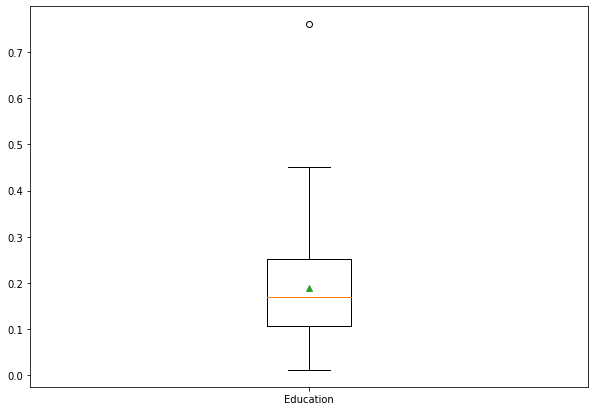

done for district Bangalore for category Education in time  0.18876290321350098


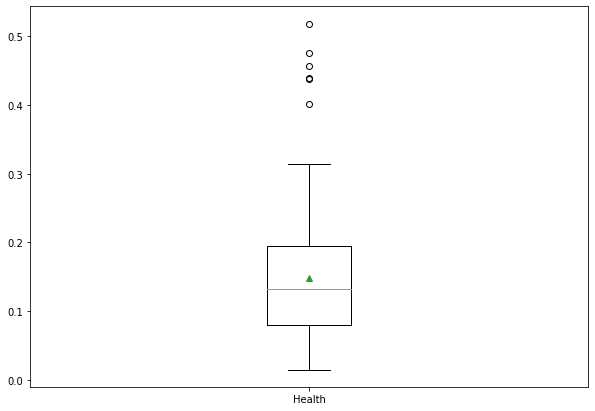

done for district Bangalore for category Health in time  0.19041800498962402


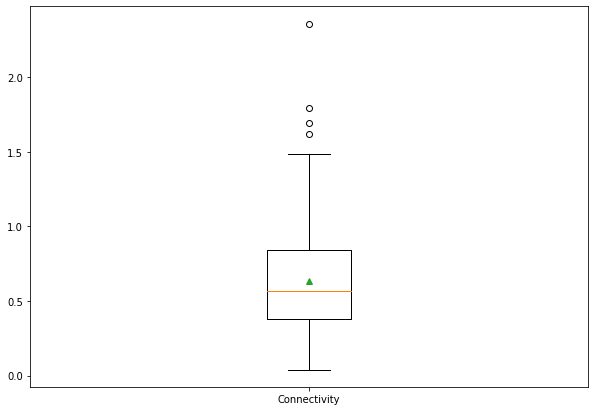

done for district Bangalore for category Connectivity in time  0.18150830268859863


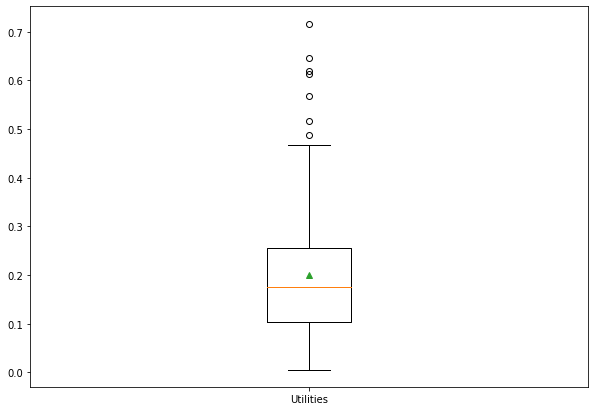

done for district Bangalore for category Utilities in time  0.20061159133911133


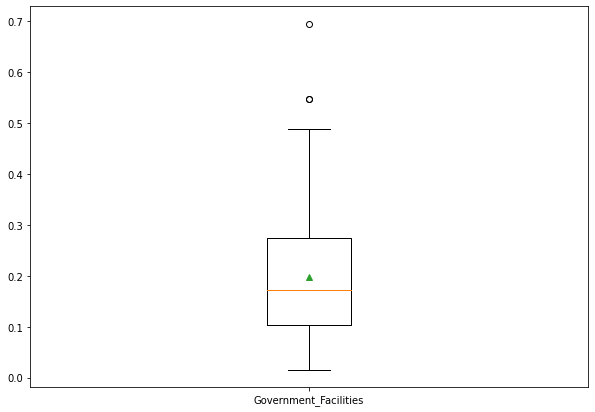

done for district Bangalore for category Government_Facilities in time  0.2239675521850586


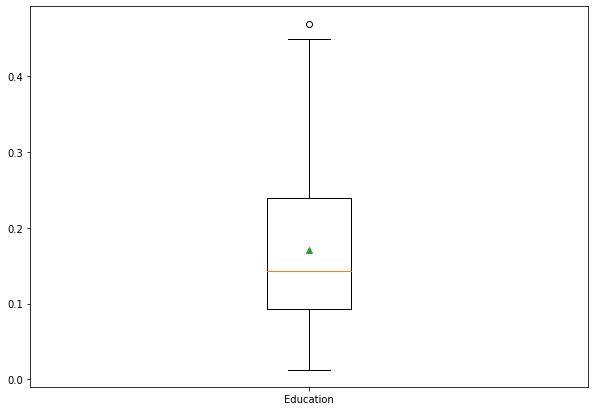

done for district Chennai for category Education in time  0.14751267433166504


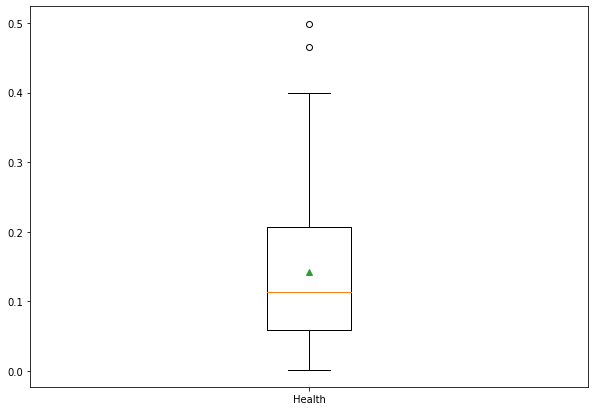

done for district Chennai for category Health in time  0.14963197708129883


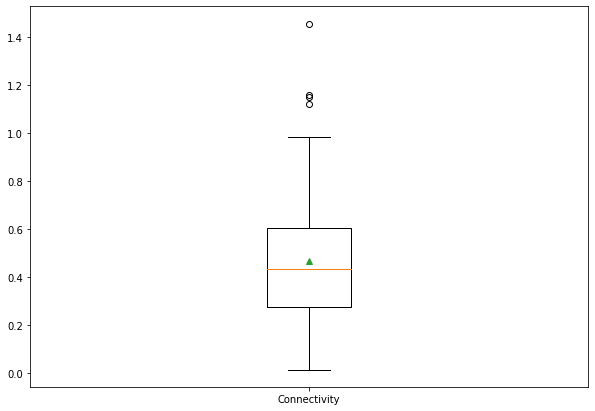

done for district Chennai for category Connectivity in time  0.15283679962158203


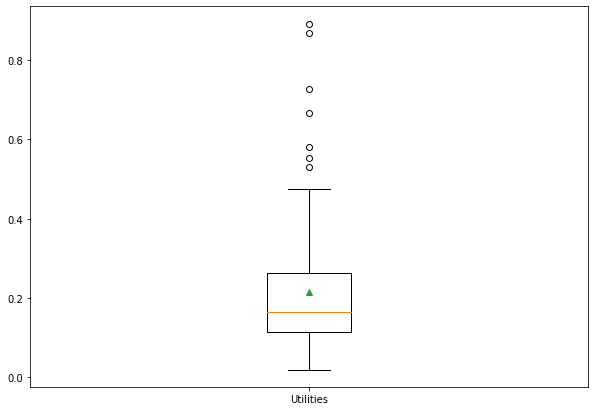

done for district Chennai for category Utilities in time  0.1488206386566162


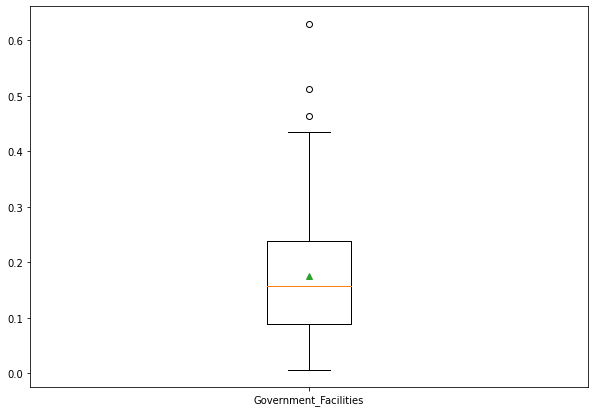

done for district Chennai for category Government_Facilities in time  0.24651336669921875


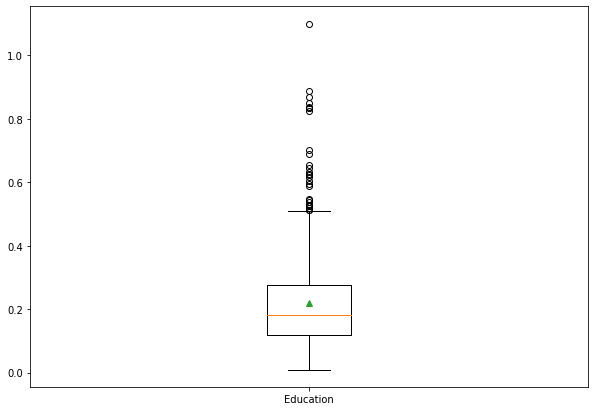

Delhi   Education  threshold distance=> 0.5074559444999424  outlier_distance--> 0.5135360646995605 lat-lon==> 28.685   76.955  outlier_grid_number--> 616  grid_class--> 5.0
done for district Delhi for category Education in time  0.1846482753753662


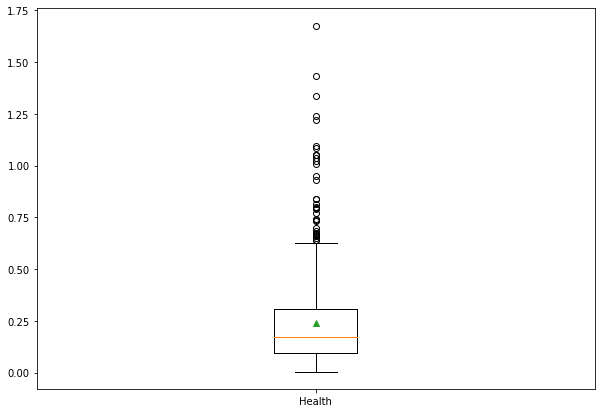

done for district Delhi for category Health in time  0.19204473495483398


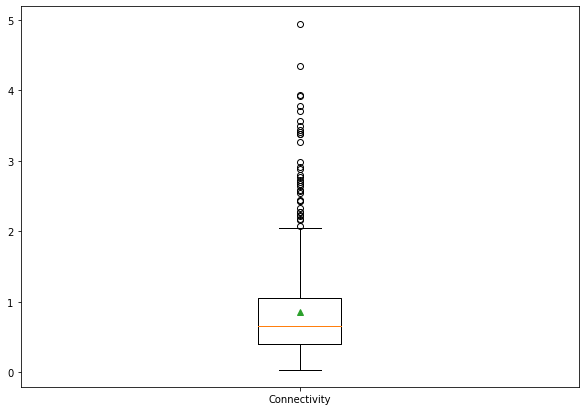

Delhi   Connectivity  threshold distance=> 2.052160281086844  outlier_distance--> 2.4261356157968086 lat-lon==> 28.785   77.05499999999999  outlier_grid_number--> 1116  grid_class--> 4.0
Delhi   Connectivity  threshold distance=> 2.052160281086844  outlier_distance--> 2.081212969540518 lat-lon==> 28.494999999999997   77.235  outlier_grid_number--> 1969  grid_class--> 4.0
done for district Delhi for category Connectivity in time  0.1821761131286621


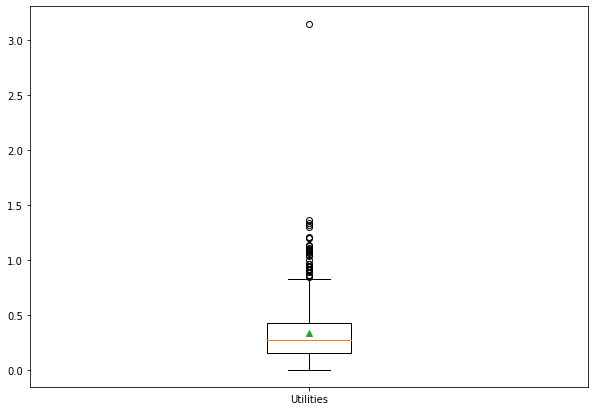

done for district Delhi for category Utilities in time  0.20557761192321777


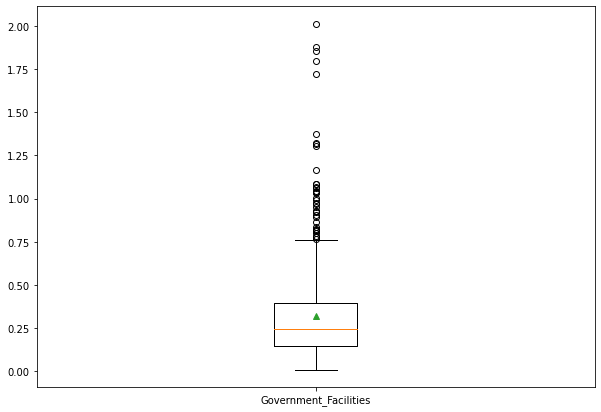

done for district Delhi for category Government_Facilities in time  0.19698071479797363


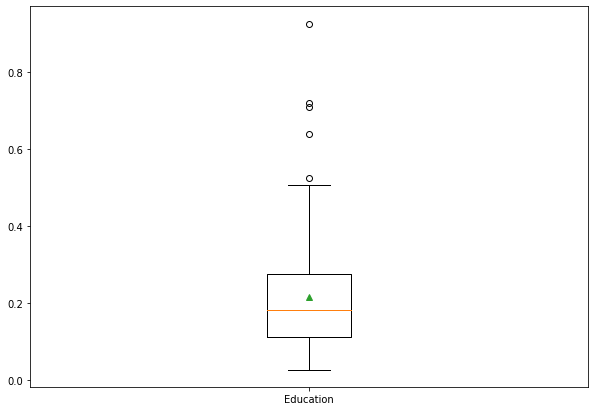

done for district Gurgaon for category Education in time  0.1831972599029541


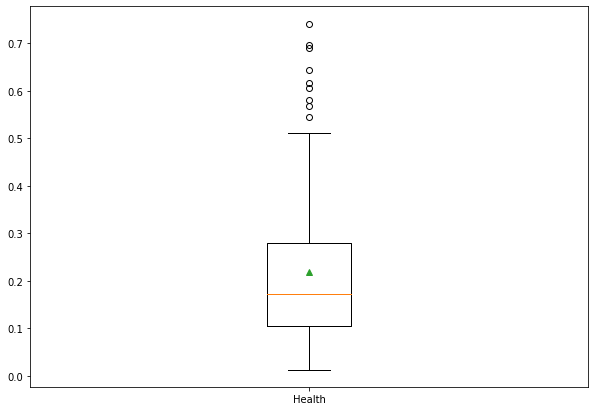

done for district Gurgaon for category Health in time  0.20378422737121582


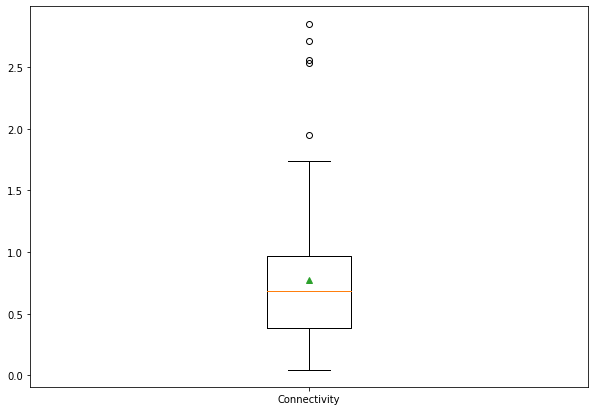

done for district Gurgaon for category Connectivity in time  0.16917657852172852


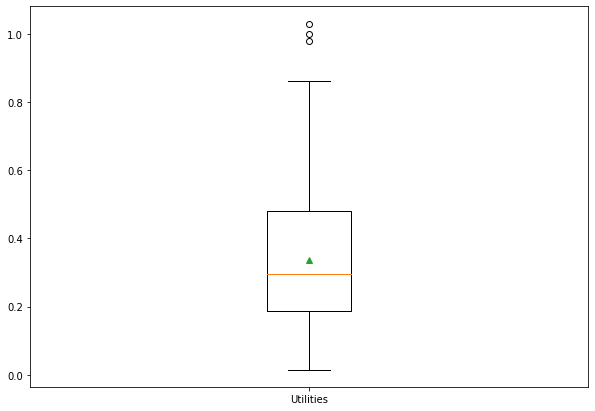

done for district Gurgaon for category Utilities in time  0.18317198753356934


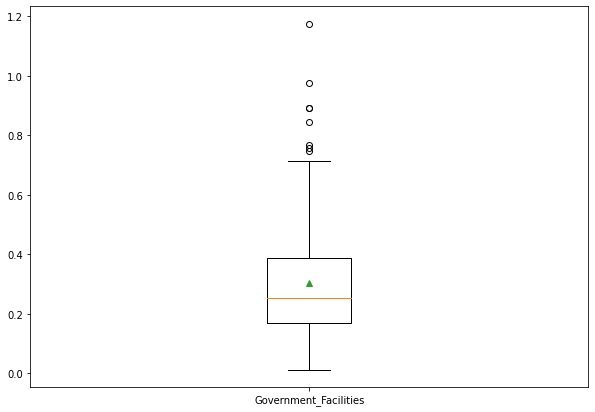

done for district Gurgaon for category Government_Facilities in time  0.18193864822387695


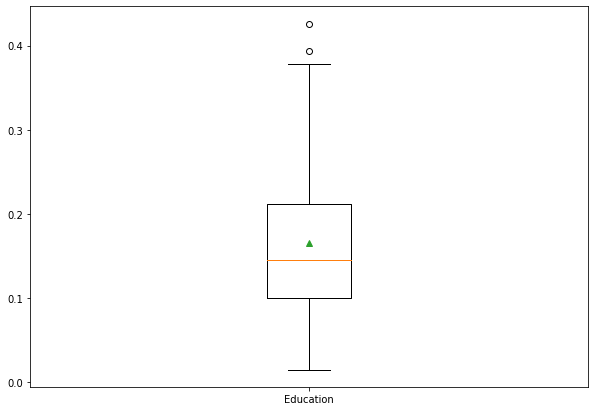

done for district Hyderabad for category Education in time  0.14751172065734863


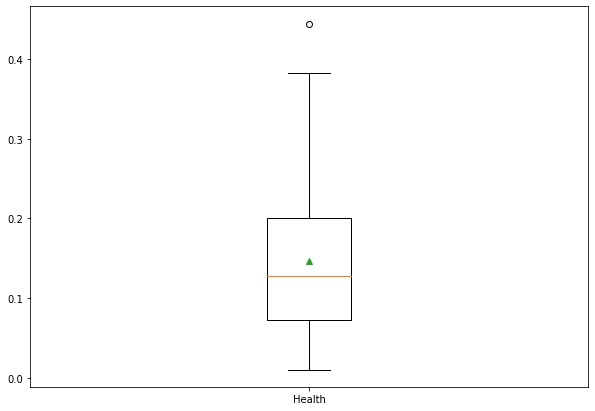

done for district Hyderabad for category Health in time  0.13694024085998535


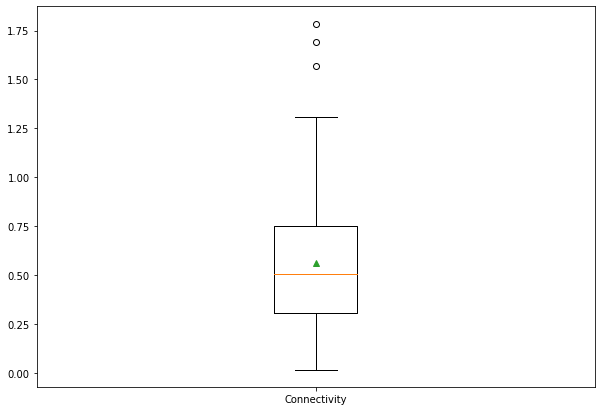

Hyderabad   Connectivity  threshold distance=> 1.3071063208629543  outlier_distance--> 1.693426562023166 lat-lon==> 17.375   78.445  outlier_grid_number--> 122  grid_class--> 4.0
Hyderabad   Connectivity  threshold distance=> 1.3071063208629543  outlier_distance--> 1.7857668782130132 lat-lon==> 17.375   78.455  outlier_grid_number--> 141  grid_class--> 4.0
Hyderabad   Connectivity  threshold distance=> 1.3071063208629543  outlier_distance--> 1.5709765668430018 lat-lon==> 17.384999999999998   78.455  outlier_grid_number--> 142  grid_class--> 4.0
done for district Hyderabad for category Connectivity in time  0.1638646125793457


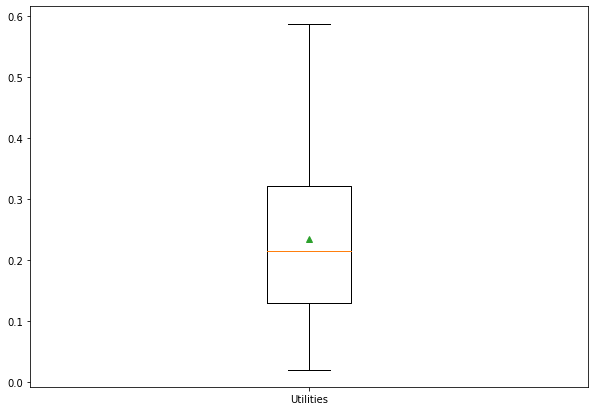

done for district Hyderabad for category Utilities in time  0.1579761505126953


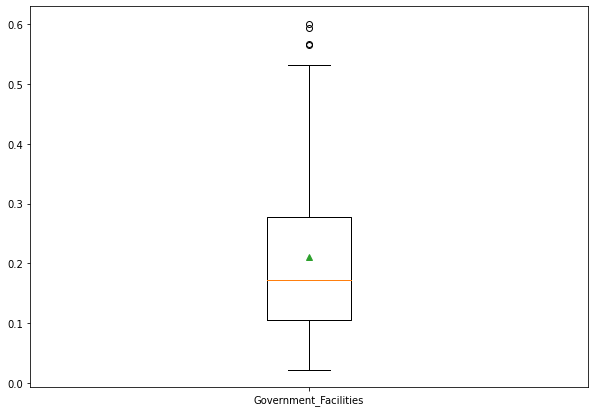

done for district Hyderabad for category Government_Facilities in time  0.16641879081726074


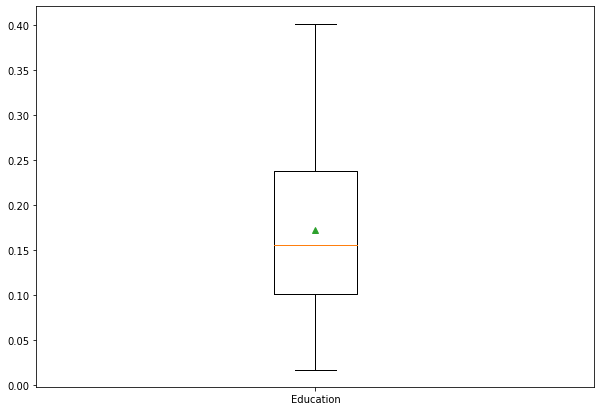

done for district Kolkata for category Education in time  0.15260791778564453


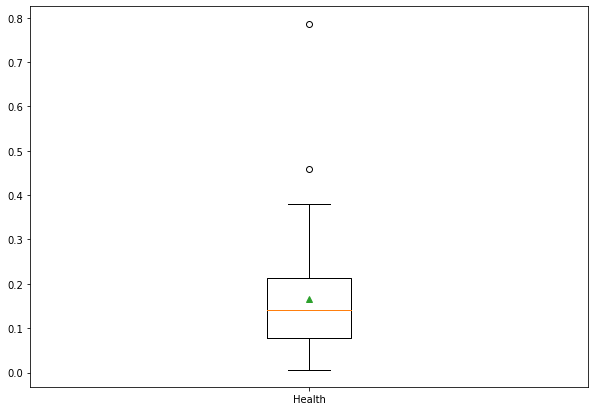

done for district Kolkata for category Health in time  0.2570517063140869


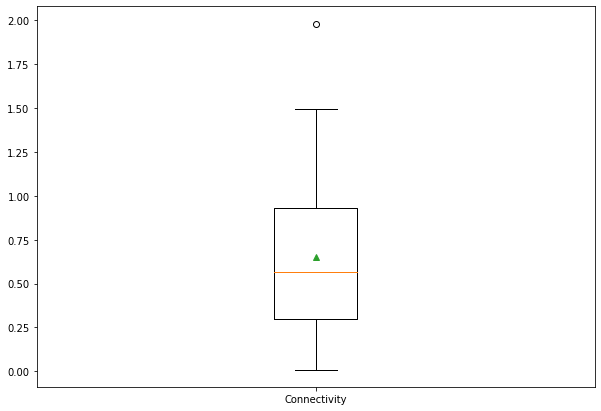

done for district Kolkata for category Connectivity in time  0.18529319763183594


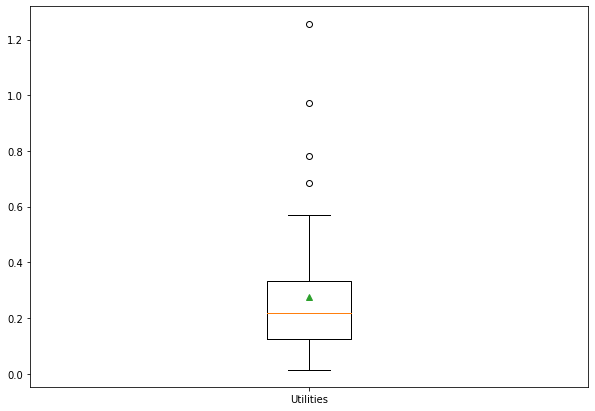

done for district Kolkata for category Utilities in time  0.14246892929077148


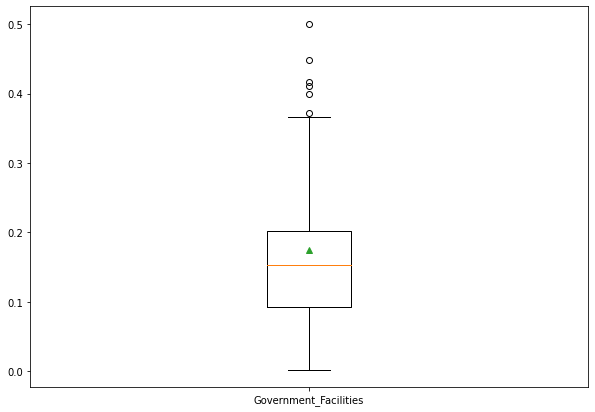

Kolkata   Government_Facilities  threshold distance=> 0.3660599791121212  outlier_distance--> 0.41657957619974856 lat-lon==> 22.535   88.375  outlier_grid_number--> 144  grid_class--> 5.0
done for district Kolkata for category Government_Facilities in time  0.1477646827697754


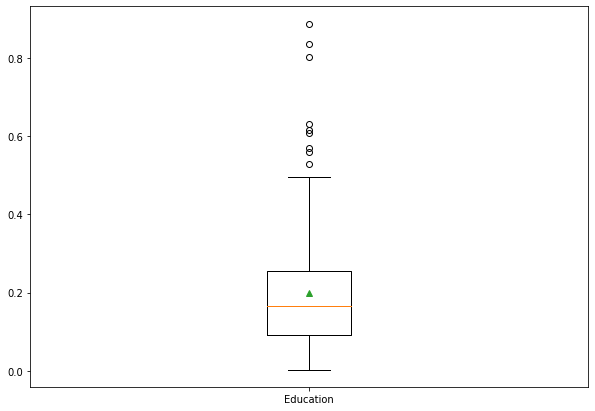

Mumbai   Education  threshold distance=> 0.4947567064464743  outlier_distance--> 0.801961691595984 lat-lon==> 19.015   72.895  outlier_grid_number--> 468  grid_class--> 5.0
done for district Mumbai for category Education in time  0.17732977867126465


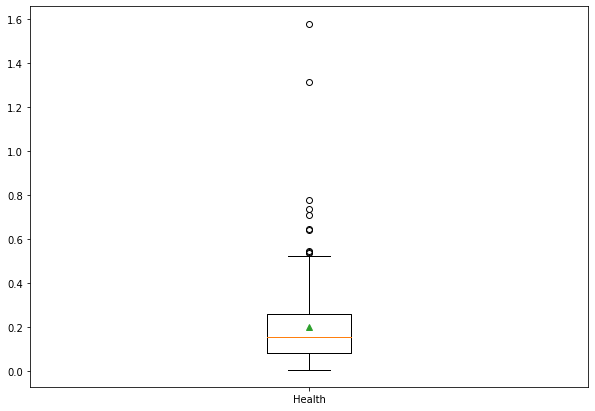

Mumbai   Health  threshold distance=> 0.520870800691359  outlier_distance--> 0.6460937103208143 lat-lon==> 19.015   72.895  outlier_grid_number--> 468  grid_class--> 5.0
done for district Mumbai for category Health in time  0.1908419132232666


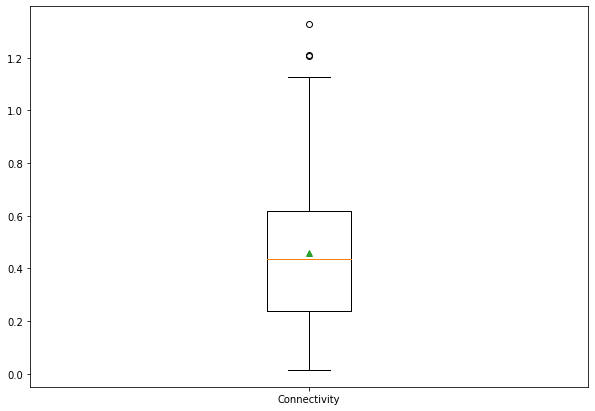

done for district Mumbai for category Connectivity in time  0.1671304702758789


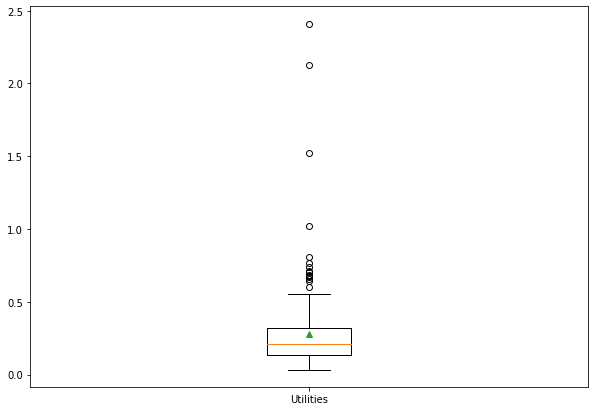

Mumbai   Utilities  threshold distance=> 0.5566812246925071  outlier_distance--> 0.6683845418746694 lat-lon==> 19.105   72.875  outlier_grid_number--> 401  grid_class--> 5.0
Mumbai   Utilities  threshold distance=> 0.5566812246925071  outlier_distance--> 1.5246311146921587 lat-lon==> 19.015   72.895  outlier_grid_number--> 468  grid_class--> 5.0
done for district Mumbai for category Utilities in time  0.15885448455810547


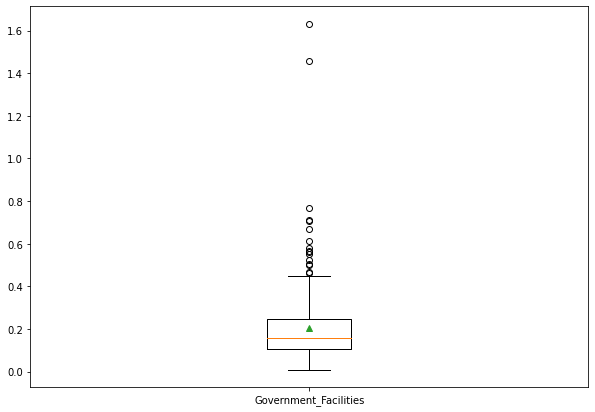

Mumbai   Government_Facilities  threshold distance=> 0.4460295005504784  outlier_distance--> 0.4981882304952889 lat-lon==> 19.105   72.875  outlier_grid_number--> 401  grid_class--> 5.0
done for district Mumbai for category Government_Facilities in time  0.1965630054473877


In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
class_type=['C1','C2','C3','C4','C5']
for i in range(len(districts)):
  category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
  for key in category_dict:
    start_time=time.time()
    category_dict[key]=category_dict[key]+outliers_cx_grid_count_list_for_nearest_amenity_indicator(districts[i],key,2019)
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
  data = {'Class': class_type, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
  df = pd.DataFrame(data, columns = data.keys())
  df.to_csv('Histogram_data_of_cx_grids_for_' + districts[i]+'for_num_of_outlier_grids_for_nearest_'+'category'+'_distance'+'.csv', index=False)

In [ ]:
def Cx_grids_count(district_name, year):
  grid_info=get_grid_info(district_name,year)
  num_combined_grids=np.sum(np.logical_or(grid_info[:,3]=='Urban',grid_info[:,3]=='PeriUrban'))
  # print(num_combined_grids)
  num_C1_grids=np.sum(grid_info[:,4]==1)
  # print(num_C1_grids)
  num_C2_grids=np.sum(grid_info[:,4]==2)
  # print(num_C2_grids)
  num_C3_grids=np.sum(grid_info[:,4]==3)
  num_C4_grids=np.sum(grid_info[:,4]==4)
  num_C5_grids=np.sum(grid_info[:,4]==5)
  return (num_C1_grids,num_C2_grids,num_C3_grids,num_C4_grids,num_C5_grids)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
C1_grids_count=[]
C2_grids_count=[]
C3_grids_count=[]
C4_grids_count=[]
C5_grids_count=[]
for i in range(len(districts)):
  start_time=time.time()
  (C1_count,C2_count,C3_count,C4_count,C5_count)=Cx_grids_count(districts[i],2019)
  C1_grids_count.append(C1_count)
  C2_grids_count.append(C2_count)
  C3_grids_count.append(C3_count)
  C4_grids_count.append(C4_count)
  C5_grids_count.append(C5_count)
  print('done for district '+districts[i]+' in time ',time.time()-start_time)
data = {'Districts': districts, "C1_grids_count": C1_grids_count, "C2_grids_count": C2_grids_count, "C3_grids_count": C3_grids_count, "C4_grids_count": C4_grids_count, "C5_grids_count": C5_grids_count}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Histogram_data_of_' + 'count_of_Cx_grids_in_combined_grids'+'.csv', index=False)

done for district Bangalore in time  0.07085156440734863
done for district Chennai in time  0.010987997055053711
done for district Delhi in time  0.05983161926269531
done for district Gurgaon in time  0.055753231048583984
done for district Hyderabad in time  0.012030601501464844
done for district Kolkata in time  0.008581399917602539
done for district Mumbai in time  0.022304534912109375


In [ ]:
def percentile_value_for_num_amenities_within_std_range_for_Cz_grids(district_name,category_name,year,z):#20 percentile value; z=1/2/3/4/5
  filename = district_name + '_num_'+category_name+'_within_std_range_from_each_grid_centre_2019.csv'
  num_arr=pd.read_csv(filename)
  grids_info=get_grid_info(district_name,year)
  num_arr=num_arr.to_numpy()
  num_arr = num_arr[:,1]
  cz_grids=num_arr[(grids_info[:,4]==z)]
  return_value=int(np.percentile(cz_grids,20))
  return return_value

In [ ]:
# for z in range(1,6,1):
#   print(z)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
class_type=['C1','C2','C3','C4','C5']
mod_class_type=['C2','C3','C4','C5']
for i in range(len(districts)):
  if (i==4):
    category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
    for key in category_dict:
      start_time=time.time()
      for z in range(2,6,1):
        category_dict[key]=category_dict[key]+[percentile_value_for_num_amenities_within_std_range_for_Cz_grids(districts[i],key,2019,z)]
      print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
    data = {'Class': mod_class_type, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Histogram_data_of_cx_grids_for_' + districts[i]+'_for_num_of_amenities_within_std_range'+'.csv', index=False)
  else:
    category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
    for key in category_dict:
      start_time=time.time()
      for z in range(1,6,1):
        category_dict[key]=category_dict[key]+[percentile_value_for_num_amenities_within_std_range_for_Cz_grids(districts[i],key,2019,z)]
      print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
    data = {'Class': class_type, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Histogram_data_of_cx_grids_for_' + districts[i]+'_for_num_of_amenities_within_std_range'+'.csv', index=False)

done for district Bangalore for category Education in time  0.3292961120605469
done for district Bangalore for category Health in time  0.32638978958129883
done for district Bangalore for category Connectivity in time  0.36202526092529297
done for district Bangalore for category Utilities in time  0.31816911697387695
done for district Bangalore for category Government_Facilities in time  0.31725287437438965
done for district Chennai for category Education in time  0.0651700496673584
done for district Chennai for category Health in time  0.060193538665771484
done for district Chennai for category Connectivity in time  0.05776238441467285
done for district Chennai for category Utilities in time  0.0693516731262207
done for district Chennai for category Government_Facilities in time  0.05743145942687988
done for district Delhi for category Education in time  0.2936587333679199
done for district Delhi for category Health in time  0.2784550189971924
done for district Delhi for category Conn

In [ ]:
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [ ]:
def calc_gini_index_for_nearest_amenity_distance_in_combined_grids(district_name,category_name,year):
  filename = district_name + '_nearest_'+category_name+'_from_each_grid_centre.csv'
  grids_info=get_grid_info(district_name,year)
  num_arr=pd.read_csv(filename)
  num_arr=num_arr.to_numpy()
  num_arr = num_arr[:,1] 
  # grid_num=np.arange(num_arr.shape[0])
  # grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  combined_grids_dist=num_arr[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  return gini(combined_grids_dist)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
for i in range(len(districts)):
  for key in category_dict:
    start_time=time.time()
    category_dict[key].append(calc_gini_index_for_nearest_amenity_distance_in_combined_grids(districts[i],key,2019))
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Histogram_data_for_gini_index_of' + '_nearest_'+'category'+'_distance_in_combined_grids_'+'.csv', index=False)

done for district Bangalore for category Education in time  0.7306673526763916
done for district Bangalore for category Health in time  0.284637451171875
done for district Bangalore for category Connectivity in time  0.3423593044281006
done for district Bangalore for category Utilities in time  0.4408447742462158
done for district Bangalore for category Government_Facilities in time  0.3387789726257324
done for district Chennai for category Education in time  0.6360175609588623
done for district Chennai for category Health in time  0.21214962005615234
done for district Chennai for category Connectivity in time  0.3556027412414551
done for district Chennai for category Utilities in time  0.26306843757629395
done for district Chennai for category Government_Facilities in time  0.31708431243896484
done for district Delhi for category Education in time  0.6464979648590088
done for district Delhi for category Health in time  0.3172478675842285
done for district Delhi for category Connectivi

In [ ]:
def calc_gini_index_for_num_amenities_within_std_range_for_combined_grids(district_name,category_name,year):#20 percentile value
  filename = district_name + '_num_'+category_name+'_within_std_range_from_each_grid_centre_'+str(year)+'.csv'
  grids_info=get_grid_info(district_name,year)
  num_arr=pd.read_csv(filename)
  num_arr=num_arr.to_numpy()
  num_arr = num_arr[:,1]
  # grid_num=np.arange(num_arr.shape[0])
  # grid_num=grid_num[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  combined_grids=num_arr[(np.logical_or((grids_info[:,3]=='PeriUrban'),(grids_info[:,3]=='Urban')))]
  return_value=gini(combined_grids)
  return return_value

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
for i in range(len(districts)):
  for key in category_dict:
    start_time=time.time()
    category_dict[key].append(calc_gini_index_for_num_amenities_within_std_range_for_combined_grids(districts[i],key,2019))
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Histogram_data_for_gini_index_of' + '_num_'+'category'+'_within_std_range_for_combined_grids'+'.csv', index=False)

done for district Bangalore for category Education in time  0.783820390701294
done for district Bangalore for category Health in time  0.4136338233947754
done for district Bangalore for category Connectivity in time  0.35086774826049805
done for district Bangalore for category Utilities in time  0.35305047035217285
done for district Bangalore for category Government_Facilities in time  0.41477060317993164
done for district Chennai for category Education in time  0.7199304103851318
done for district Chennai for category Health in time  0.29787278175354004
done for district Chennai for category Connectivity in time  0.2879600524902344
done for district Chennai for category Utilities in time  0.2952911853790283
done for district Chennai for category Government_Facilities in time  0.3134114742279053
done for district Delhi for category Education in time  0.7231097221374512
done for district Delhi for category Health in time  0.8429532051086426
done for district Delhi for category Connectiv